# Figures for Comprehensive Exam Paper
#### David W. Barker

## Purpose: 
The purpose of this notebook is to put all of the code to create the figures for my comps in one place. My other notebooks have been getting extremely messy. This will focus on the second half of my paper after the exotic models. I may add the exotic models into this notebook later, but as I am a bit pressed for time right now, I'll stick to the figures I have yet to make.

In [1]:
# Boilerplate

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
import healpy as hp
from PIL import Image
import matplotlib.animation as animation
from astropy.io import fits
import os
import copy
from pylinex import Fitter, BasisSum, PolynomialBasis, MetaFitter, AttributeQuantity
from pylinex import Basis
from pylinex import TrainedBasis
import pylinex
import py21cmsig
import importlib
import corner
import lochness
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from importlib import reload
from pylinex import RepeatExpander, ShapedExpander, NullExpander,\
    PadExpander, CompiledQuantity, Extractor,  CalculatedQuantity
import spiceypy as spice
from datetime import datetime
import enlighten

# color map for all the plots:
cmap = "viridis"

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

# Imporant constants
NSIDE = 32 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)
location = (-23.815,182.25)  # The lat lon location of the moon landing site
spice_kernels = "/home/dbarker7752/lochness/input/spice_kernels/" #location of the spice kernels
frequencies = np.arange(6,50,0.1)

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

# ULSA map 64 bit
ULSA_direction_raw_64 = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/100.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=64,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw_64[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw_64[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(hp.nside2npix(64))
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw_64[0].data)
for i,data in enumerate(ULSA_direction_raw_64[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction_64 = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map_64 = ULSA_direction_64    # default galaxy map


# ULSA map 32 bit
ULSA_direction_raw = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/000.fits")
ULSA_frequency = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/210.fits")
ULSA_constant = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/220.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(NPIX)
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw[0].data)
for i,data in enumerate(ULSA_direction_raw[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map = ULSA_direction    # default galaxy map
test_times1 = [[2026,12,22,1,0,0]]   # list of times LOCHNESS will rotate the sky for 
frequency_array = np.array(range(1,51))   # list of frequencies we're evaluating at   

# modifies the galaxy map to not have the CMB (to make it consistent with the delta CMB convention of the signal)
galaxy_map_minCMB = copy.deepcopy(galaxy_map)
redshift_array = 1420.4/frequency_array-1
# This loop creates a CMB subtracted galaxy map to input into LOCHNESS
for i,j in enumerate(redshift_array):
    galaxy_map_minCMB[i] = galaxy_map[i] - py21cmsig.T_gamma(j)
galaxy_map_minCMB[np.where(galaxy_map_minCMB<0.0)] = 0   # Gets rid of the negatives that plague this ULSA map (not sure why they are they)
f = h5py.File("/home/dbarker7752/21_cm_group/foreground_array_minCMB","r")
foreground_array_minCMB = f["foreground_array"]


# radiometer noise
sigT = lambda T_b, dnu, dt: T_b/(np.sqrt(dnu*dt))
# Noise parameters
dnu = 1e6
dt = 1000*3600 # first number is the number of hours of integration time

# Synchrotron Equation
synch = lambda f,A,B,c : A*(f/408)**(B+c*np.log(f/408))  # taken from page 6 of Hibbard et al. 2023 Apj. Arbitrarily chose 25 as my v0

# This identifies the pixels of the absorption region
vec = hp.ang2vec(np.pi/2, 0)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.85)
absorp_map = copy.deepcopy(ULSA_direction[7])
# absorp_map[indices] = 10000000
absorp_indices = indices[np.where(absorp_map[indices] < 1450000)][750:906]
absorp_map[absorp_indices] = 10000000

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]

# frequencies = np.arange(6,50,0.1)
frequencies = np.arange(6,50,0.25)
## RMS ##
#simulation_test = py21cmsig.simulation_run_raw(frequencies,files[0],foreground_array_minCMB,test_times1,dnu,dt,omR0,omM0,omK0,omL0,omB0) # needs to be run to get RMS, that's its only purpose

rms_mean = 0.05
rms_std = 0.009


# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction,7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]

# creates the fiducial Lambda CDM signal
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

# This creates the sky maps that are properly rotated and normalized
beams = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams[n][nu] = normalized_beam

f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams","r")
beams = f["normalized_beams"]

beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

save_path = "/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/" 

# creates a perfect beam that does not distort the foreground at all, just cuts it off at the horizon
data1=(foreground_array_minCMB[0]*beams[1])
test44=np.ones(NPIX)
test44[np.where(data1[49] == 0)] = 0
perfect_beam = test44
perfect_beam_normalized = perfect_beam/perfect_beam.sum()
perfect_beam_normalized.sum()
perfect_beam_array = np.zeros((50,NPIX))
for n in range(50):
    perfect_beam_array[n] = perfect_beam_normalized

# creates a perfect signal that is only adjusted by the horizon
perfect_signal_raw = np.zeros((50))
for n in range(50):
    perfect_signal_raw[n] = np.sum(foreground_array_minCMB[0][n]*perfect_beam_normalized)

pb_interp = scipy.interpolate.CubicSpline(range(1,51),perfect_signal_raw)
perfect_signal = pb_interp(frequencies)

# This creates the sky maps that are properly rotated and normalized 64 bit version. This is loaded in a cell below
# NSIDE = 64 # resolution of the map
# NPIX = hp.nside2npix(NSIDE)
# beams_64 = np.zeros((len(files),50,NPIX))
# beam_euler_angle = [0,90,90]
# derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
# beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams_64[n][nu] = normalized_beam

## Loaded in signal training sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]


/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.169 s.


Prepared Haslam map in 0.121 s.


100%|██████████| 221/221 [00:04<00:00, 50.00it/s]


In [2]:
#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

### ULSA Galaxy Example and ULSA Galaxy Rotated Example

Text(0.5, 1.0, 'ULSA Galaxy Map at 7 MHz Rotated')

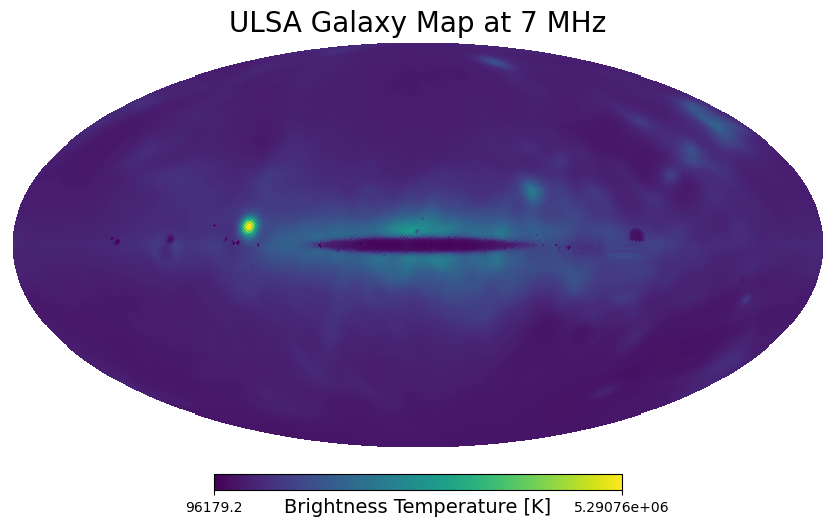

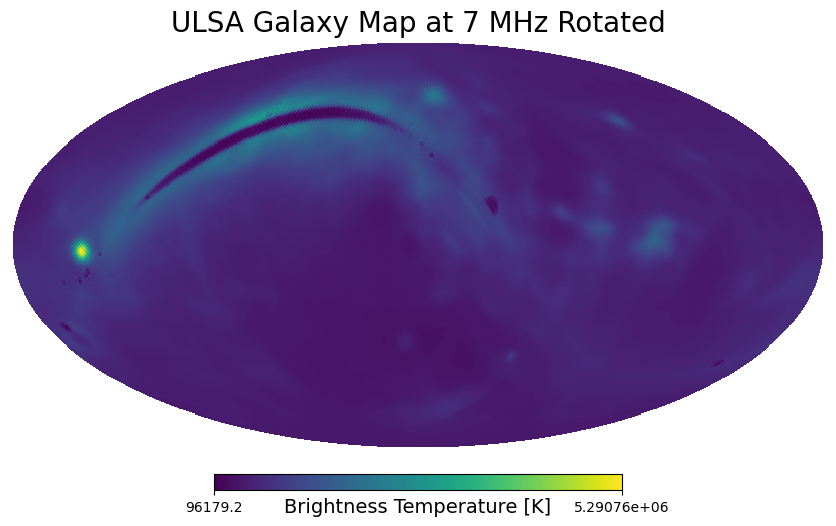

In [4]:
# ULSA Galaxy Example and ULSA Galaxy Rotated Example

# Standard unrotated galaxy
hp.mollview(galaxy_map_64[7],unit="Brightness Temperature [K]",cmap= cmap)
plt.title("ULSA Galaxy Map at 7 MHz" ,fontsize=20)
# plt.savefig(save_path+"ULSA_64bit_Standard")


# ## next few lines create and save the rotated galaxy to save time when loading this up again.
# # galaxy creation part
# # Now we rotate it into a frame consistent with a LuSEE-Night observation window.
# rotated_64_ULSA = lochness.LOCHNESS(spice_kernels,test_times1,location,galaxy_map=galaxy_map_64).lunar_frame_galaxy_maps[0]
# rotated_64_ULSA[np.where(rotated_64_ULSA<0.0)] = 0
# # HDF5 part
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","w")
# hdf5.create_dataset("rotated_sky_maps",data=rotated_64_ULSA)
# hdf5.close()
# ## End of galaxy map creation and hdf5 saving code

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

hp.mollview(rotated_64_ULSA[7],min=96179.2,max=5290760,cmap=cmap,unit="Brightness Temperature [K]")
plt.title("ULSA Galaxy Map at 7 MHz Rotated" ,fontsize=20)
# plt.savefig(save_path+"ULSA_64bit_Rotated")

## Five Region Model with Rotated Galaxy
- We'll use the rotated galaxy for examples from here on out since that's the actual foreground we used as our base model.

100%|██████████| 10/10 [00:00<00:00, 5490.65it/s]


Text(0.5, 1.0, 'Five Region Model Rotated')

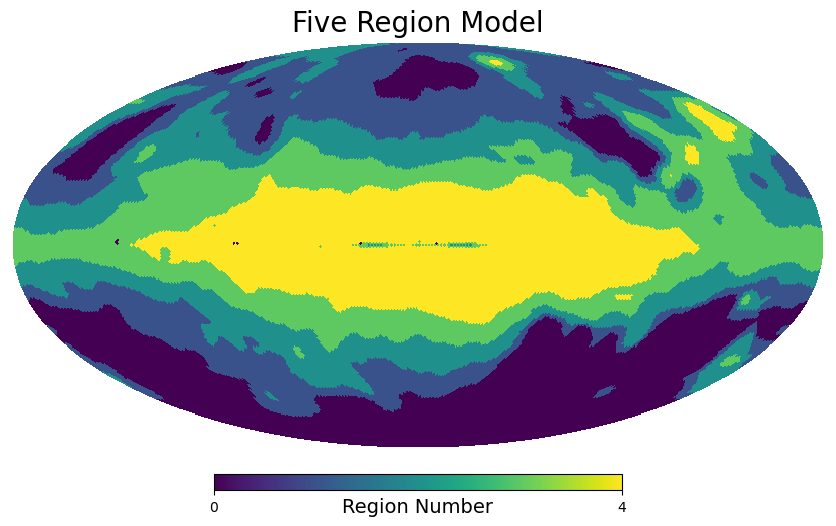

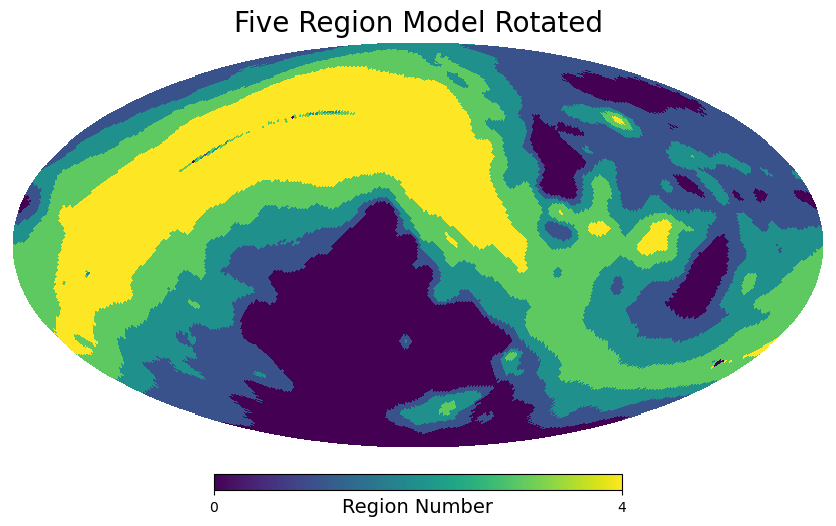

In [ ]:
# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction_64,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]
hp.mollview(best_foreground_model[11],unit = "Region Number",cmap=cmap)
plt.title("Five Region Model", fontsize=20)
# plt.savefig(save_path+"five_region_model")

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,rotated_64_ULSA,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]
hp.mollview(best_foreground_model_rotated[11],unit = "Region Number")
plt.title("Five Region Model Rotated", fontsize=20)
# plt.savefig(save_path+"five_region_model_rotated")

## Varied Foreground Example

100%|██████████| 2/2 [00:00<00:00, 12557.80it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 107.93it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 219.85it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 13819.78it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


Text(0.5, 1.0, 'Difference of Varied Foreground from Base ULSA Model')

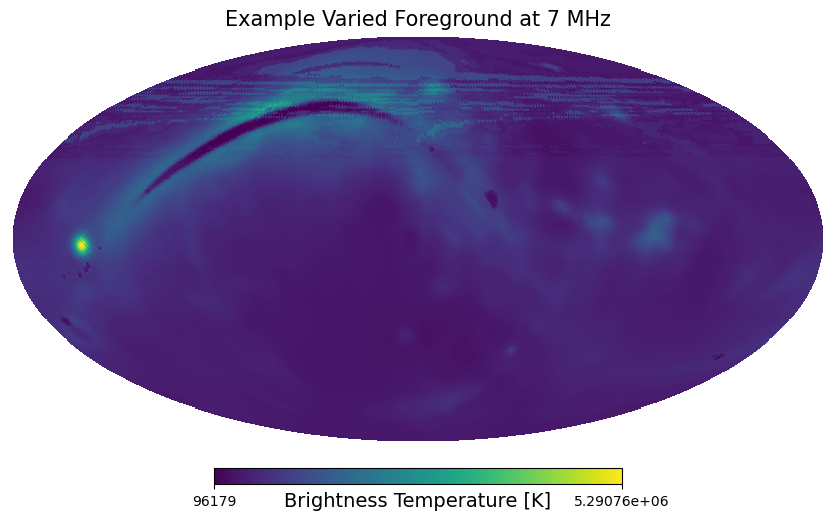

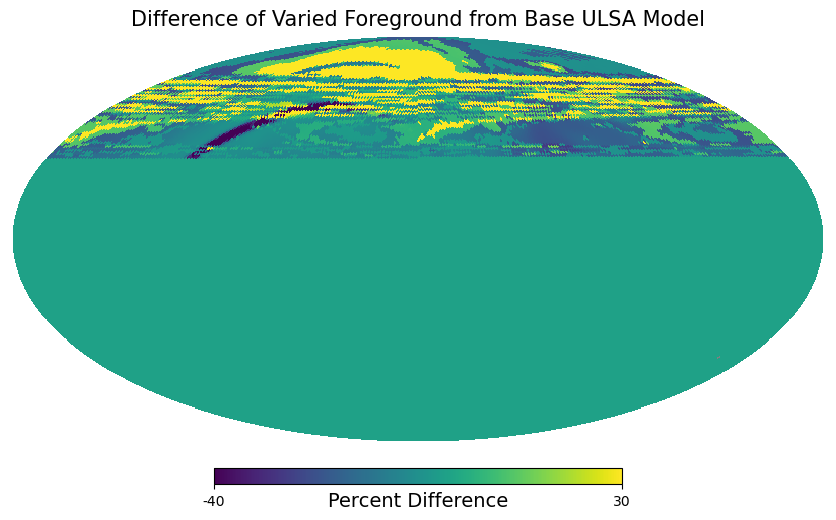

In [3]:
# Simulation and Training Set for a single LST
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")


# data = simulation_test_beam[0]
# one_sigma_rms = rms_std
# training_set = varied_regolith_training_set_raw
# training_set_parameters = varied_regolith_training_set_raw_params
# signal_extraction_return = signal_extraction(data,rms_mean,rms_std,training_set,training_set_parameters,N=10000,sigma_tolerance=3,iteration_limit=10)


## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = np.array(hdf5["rotated_sky_maps"])
## End of hdf5 loading code

copy_rotated_ULSA = copy.deepcopy(rotated_64_ULSA)
copy_rotated_ULSA[7][region_indices_rotated[0]] += foreground_run_set[5][0][0][4]
copy_rotated_ULSA[7][region_indices_rotated[1]] += foreground_run_set[5][0][1][4]
copy_rotated_ULSA[7][region_indices_rotated[2]] += foreground_run_set[5][0][2][4]
copy_rotated_ULSA[7][region_indices_rotated[3]] += foreground_run_set[5][0][3][4]
copy_rotated_ULSA[7][region_indices_rotated[4]] += foreground_run_set[5][0][4][4]

copy_rotated_ULSA[40][region_indices_rotated[0]] += foreground_run_set[5][100][0][136]
copy_rotated_ULSA[40][region_indices_rotated[1]] += foreground_run_set[5][100][1][136]
copy_rotated_ULSA[40][region_indices_rotated[2]] += foreground_run_set[5][100][2][136]
copy_rotated_ULSA[40][region_indices_rotated[3]] += foreground_run_set[5][100][3][136]
copy_rotated_ULSA[40][region_indices_rotated[4]] += foreground_run_set[5][100][4][136]

hp.mollview(copy_rotated_ULSA[7],unit="Brightness Temperature [K]",min=96179, max= 5290760,cmap=cmap )
plt.title("Example Varied Foreground at 7 MHz", fontsize=15)
# plt.savefig(save_path+"example_foreground_trainingset_7MHz")
hp.mollview((copy_rotated_ULSA[7]-rotated_64_ULSA[7])/rotated_64_ULSA[7]*100,min=-40,max=30,unit="Percent Difference",cmap=cmap)
plt.title("Difference of Varied Foreground from Base ULSA Model" ,fontsize = 15)
# plt.savefig(save_path+"example_fgts_diff")

## Varied Foreground Training Set Distribution

100%|██████████| 176/176 [00:00<00:00, 208.98it/s]


[[1.  1. ]
 [3.4 3.4]
 [4.6 4.6]]


100%|██████████| 2/2 [00:00<00:00, 12.42it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 10994.24it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


100%|██████████| 10/10 [00:00<00:00, 4883.91it/s]


Text(0, 0.5, 'Percent Difference from ULSA Base')

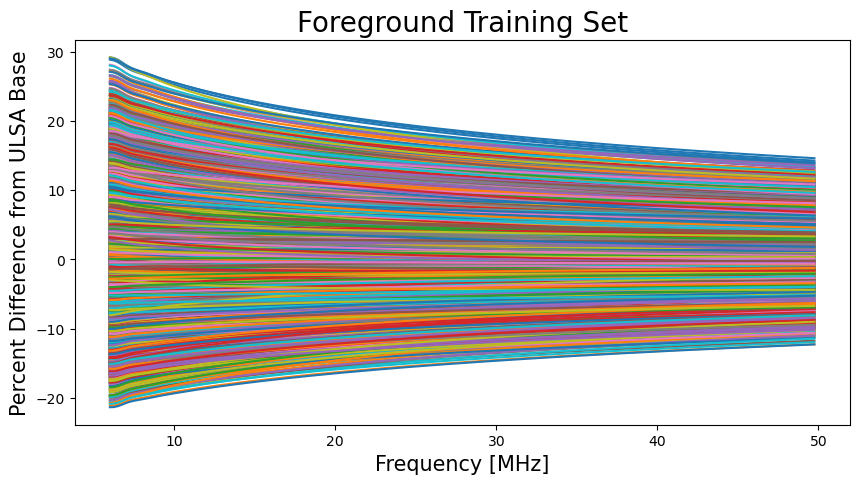

In [15]:

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 10000
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

## This portion creates the foreground training set
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

best_foreground_model_rotated_32 = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated_32 = best_foreground_model_rotated_32[10]
# Let's weight each region correctly:
masked_indices = np.where(beams[0][-1] <= 0)[0]
masked_region_indices = {}
for r in region_indices_rotated_32:  # Creates list of indices per region that exist within the beam
    ones_array = np.ones(NPIX)
    ones_array[masked_indices] = 0
    zeros_array = np.zeros(NPIX)
    zeros_array[region_indices_rotated_32[r]] = 1
    masked_region_indices[r] = np.where(ones_array*zeros_array == 1)

region_1_weight = masked_region_indices[0][0].shape[0]/(NPIX/2)
region_2_weight = masked_region_indices[1][0].shape[0]/(NPIX/2)
region_3_weight = masked_region_indices[2][0].shape[0]/(NPIX/2)
region_4_weight = masked_region_indices[3][0].shape[0]/(NPIX/2)
region_5_weight = masked_region_indices[4][0].shape[0]/(NPIX/2)
region_weights = np.array((region_1_weight,region_2_weight,region_3_weight,region_4_weight,region_5_weight))
region_weights

foreground_training_set = np.zeros((N,len(frequencies)))
for n in range(N):
    new_T = 0
    for r in range(5):
        new_T += foreground_run_set[5][n][r]*region_weights[r]
    foreground_training_set[n] = perfect_signal + new_T

# Displays a training set of ONLY the foregrounds. No beam weights.

plt.figure(figsize=(10, 5))

for n in range(10000):
    plt.plot(frequencies, (foreground_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Foreground_Training_Set")

## Beam Example

Text(0.5, 1.0, 'Beam-weighted Foreground at 40 MHz')

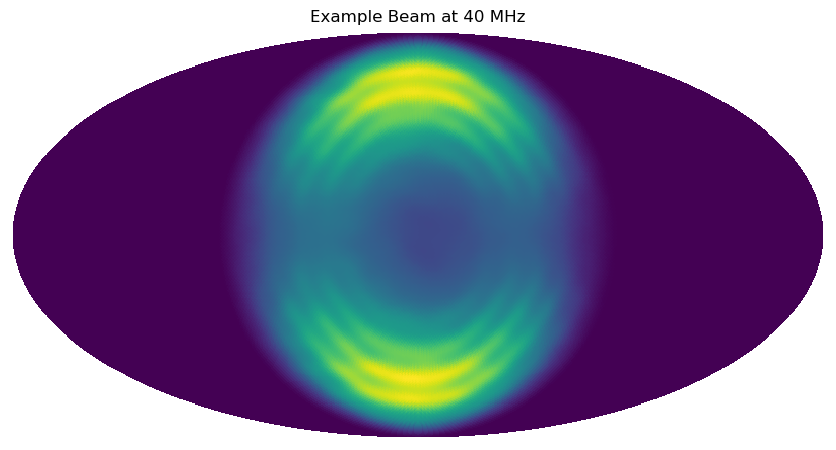

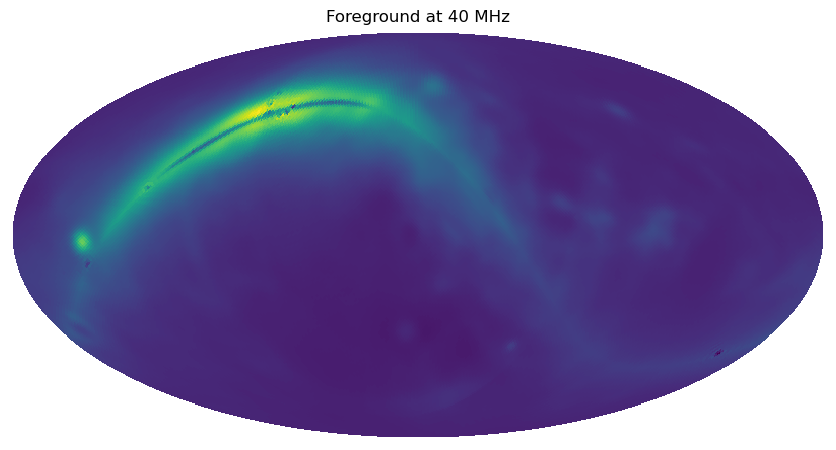

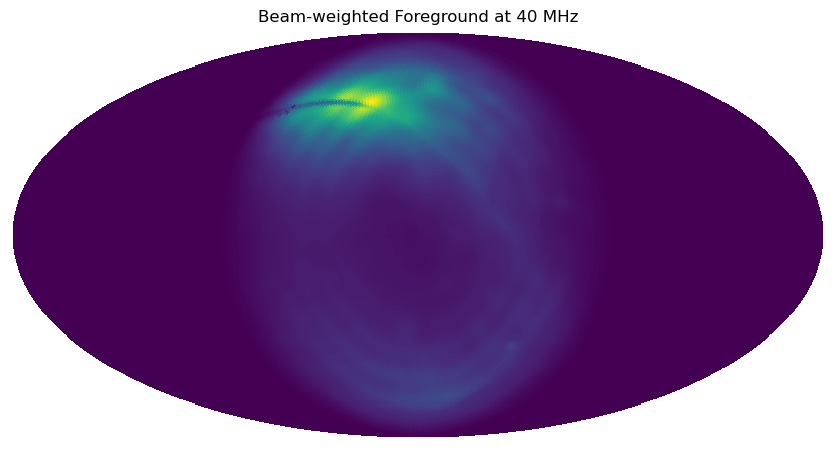

In [16]:
# This creates the sky maps that are properly rotated and normalized 64 bit version
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
beams_64 = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
beam_maps= derp["raw_beam_maps"]

### Creates an h5py file for 64 bit normalized beams
# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams_64[n][nu] = normalized_beam
# f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams_64","w")
# f.create_dataset("normalized_beams",data=beams_64)
# f.close()
### End hdf5 creation code

### Loads hdf5 for normalized beams
f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams_64","r")
beams_64 = f["normalized_beams"]
### End loading code 

hp.mollview(beams_64[0][40], cbar=False,cmap=cmap)
plt.title("Example Beam at 40 MHz")
# plt.savefig(save_path+"Example_Beam_40MHz")

# And now to weight it with the foreground
# First a foreground without a colorbar:
hp.mollview(rotated_64_ULSA[40],cbar=False,cmap=cmap)
plt.title("Foreground at 40 MHz")
# plt.savefig(save_path+"ULSA_rot_40MHz_nocbar")

# now beam_weighted:
hp.mollview(rotated_64_ULSA[40]*beams_64[0][40], cbar=False,cmap=cmap)
plt.title("Beam-weighted Foreground at 40 MHz")
# plt.savefig(save_path+"ULSA_40MHz_beam-weighted")

## Beam Training Set

100%|██████████| 176/176 [00:03<00:00, 52.25it/s]


[[1.  2. ]
 [3.3 3.5]
 [4.2 4.7]]


100%|██████████| 10000/10000 [00:00<00:00, 97466.93it/s]


[0, 0, 0]


100%|██████████| 2/2 [00:00<00:00, 5472.02it/s]


[[ 1.59202418e+01  1.59202418e+01 -2.65279830e+00 -2.65279830e+00
  -1.37293590e-02 -1.37293590e-02]
 [ 1.66130589e+01  1.66130589e+01 -2.69062579e+00 -2.69062579e+00
  -1.47582387e-02 -1.47582387e-02]
 [ 1.89769800e+01  1.89769800e+01 -2.68235795e+00 -2.68235795e+00
  -1.34495335e-02 -1.34495335e-02]
 [ 2.42115565e+01  2.42115565e+01 -2.66682587e+00 -2.66682587e+00
  -1.20169084e-02 -1.20169084e-02]
 [ 5.22431891e+01  5.22431891e+01 -2.65055339e+00 -2.65055339e+00
  -2.42275191e-02 -2.42275191e-02]]


Text(0, 0.5, 'Percent Difference from ULSA Base')

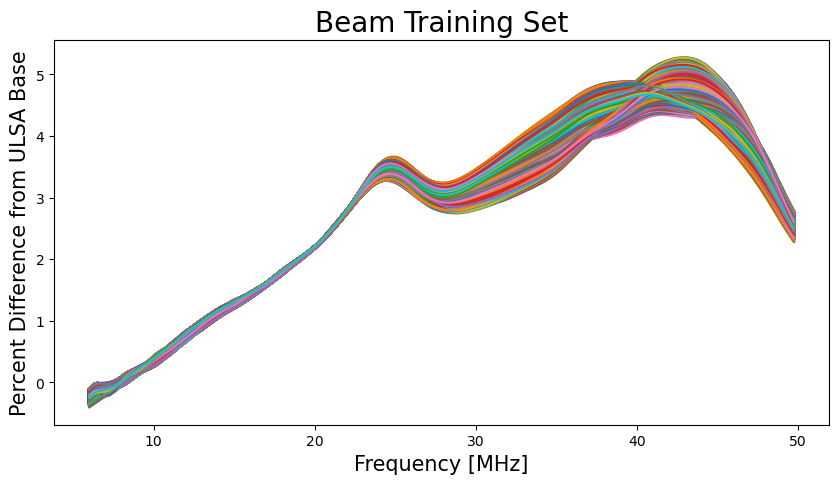

In [17]:

## Creates a training set with varied beams:

custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0,0,0]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 10000 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

# Beam Training Set

plt.figure(figsize=(10, 5))

beam_training_set=foreground_run_set[3]

# Displays a training set of the beams weighting the ULSA base model.
for n in range(10000):
    plt.plot(frequencies, (beam_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Beam Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Beam_Training_Set")

100%|██████████| 176/176 [00:01<00:00, 165.93it/s]


[[1.  2. ]
 [3.3 3.5]
 [4.2 4.7]]


100%|██████████| 500/500 [00:02<00:00, 185.31it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 8603.70it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


Text(0, 0.5, 'Percent Difference from ULSA Base')

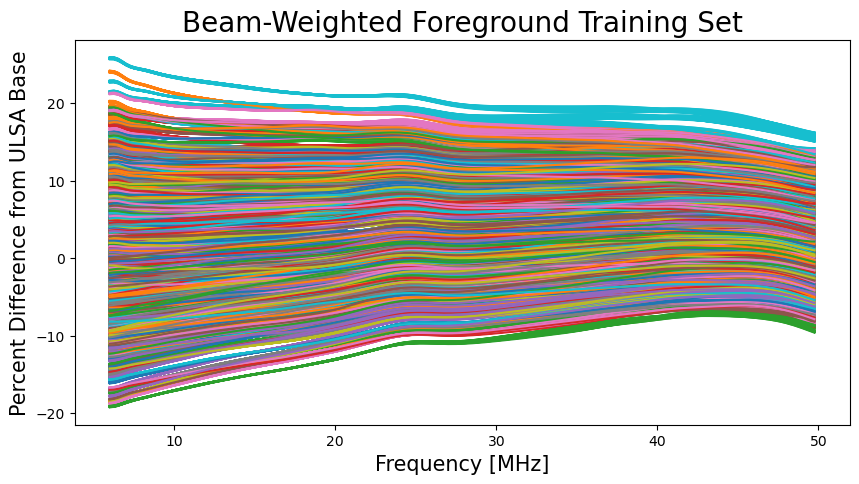

In [18]:
## Creates a training set with varied beams:

custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                              # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

plt.figure(figsize=(10, 5))
# Beam-Weighted Foreground Training Set
beam_foreground_training_set=foreground_run_set[3]

# Displays a training set of the beams weighting the ULSA base model.
for n in range(20000):
    plt.plot(frequencies, (beam_foreground_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Beam-Weighted Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Beam_Foreground_Training_Set")

## PYLINEX flow-chart figures (at least the ones we haven't already made)

In [ ]:
# Lambda CDM Training Set
# plt.figure(figsize=(10, 5))
# for n in range(10000):
#     plt.plot(frequencies,labmdaCDM_training_set[n])
# plt.title("Lambda CDM Signal Training Set",fontsize=20)
# plt.ylabel(r"$\delta T_b$",fontsize=15)
# plt.xlabel("Frequency [MHz]",fontsize=15)
# plt.savefig(save_path+"Lambda_CDM_Training_Set")

Text(0.5, 0, 'Frequency [MHz]')

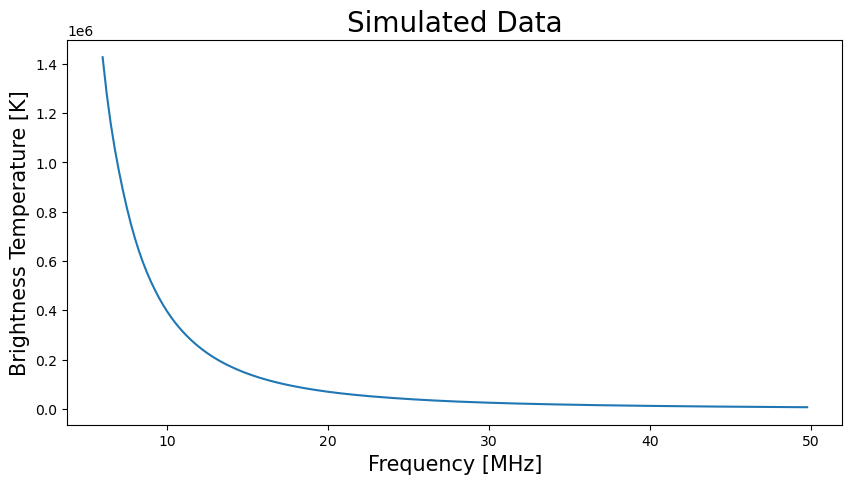

In [19]:
# Simulation Data

plt.figure(figsize=(10, 5))
plt.plot(frequencies, simulation_test_beam[0])
plt.title("Simulated Data",fontsize=20)
plt.ylabel("Brightness Temperature [K]",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)
# plt.savefig(save_path+"Simulated_Signal")


In [4]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = labmdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=30,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,30)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter2.sizes['Foreground']
num_signal_terms = fitter2.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter2.chi_squared} Chi Squared")
print(f"{fitter2.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")




  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 3682.44it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:00<00:00, 181.20it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 500/500 [00:01<00:00, 256.92it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 2/2 [00:00<00:00, 8962.19it/s]


[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.42275312e-02]]
[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.422

NameError: name 'labmdaCDM_training_set' is not defined

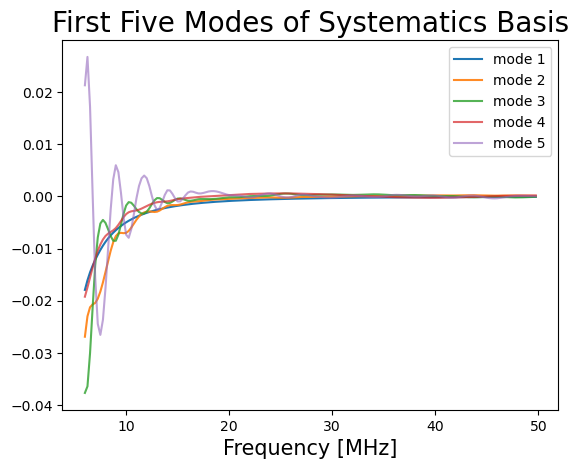

In [21]:

# Plots the foreground basis
for n in range(5):
    plt.plot(frequencies, foreground_basis.basis[n],label=f"mode {n+1}",alpha = 1-0.1*n)
plt.title("First Five Modes of Systematics Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"Foreground_Basis")

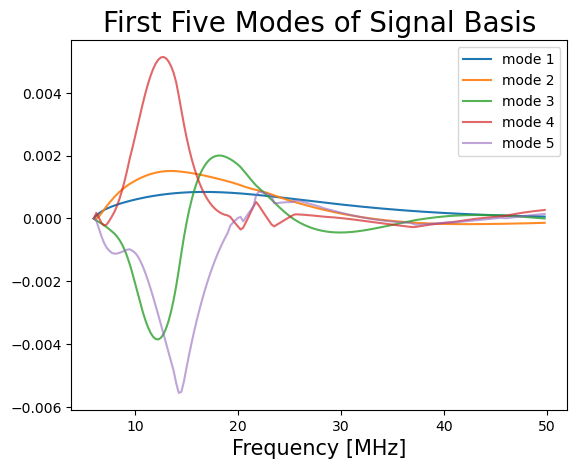

In [22]:
# Plots the foreground basis
for n in range(5):
    plt.plot(frequencies, signal_basis.basis[n],label=f"mode {n+1}",alpha = 1-0.1*n)
plt.title("First Five Modes of Signal Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"Signal_Basis")

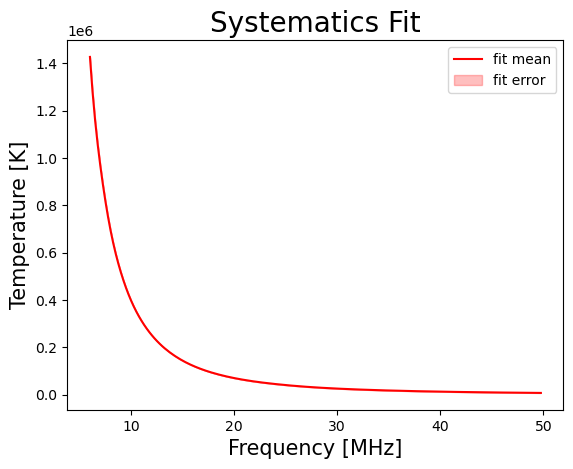

In [23]:
plt.plot(frequencies, fitter2.subbasis_channel_mean("Foreground"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Foreground")+fitter2.subbasis_channel_error("Foreground"),fitter2.subbasis_channel_mean("Foreground")-fitter2.subbasis_channel_error("Foreground"),label="fit error",alpha=0.25,color="red")
plt.title("Systematics Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"example_foreground_fit")

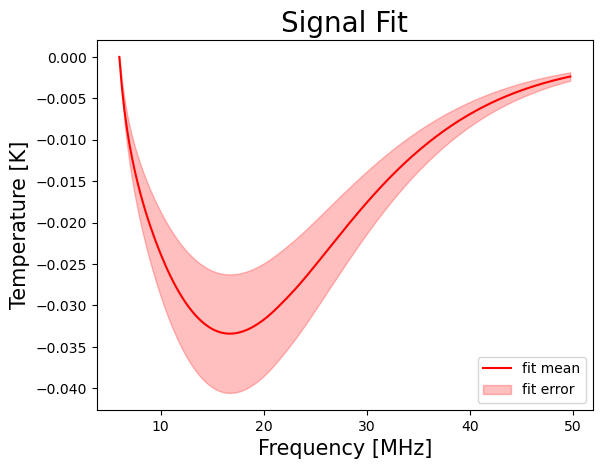

In [24]:
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"example_signal_fit")

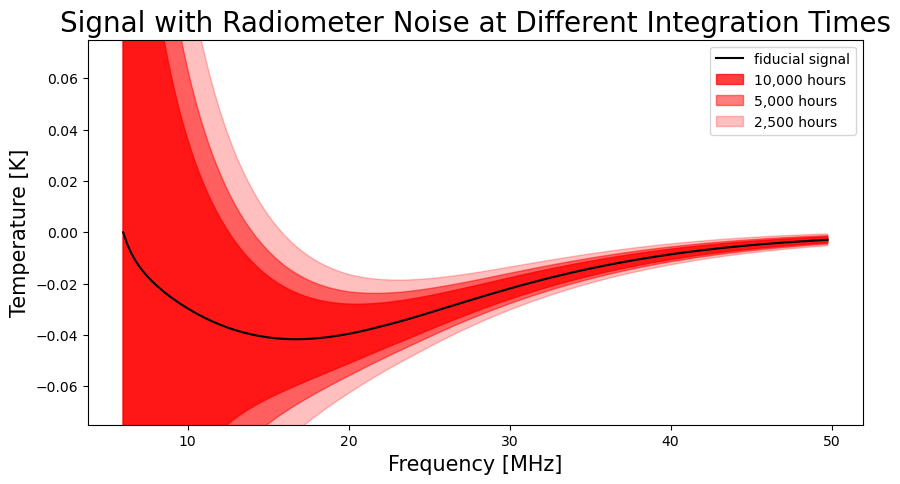

In [ ]:
# This is a noise figure for Jack, but might include this in my paper near the noise section...maybe

plt.figure(figsize=(10, 5))
plt.plot(frequencies, simulation_test_beam[1],label = "fiducial signal", c="black")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],dnu,10000*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],dnu,10000*3600),label="10,000 hours",alpha=0.75,color="red")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],dnu,5000*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],dnu,5000*3600),label="5,000 hours",alpha=0.5,color="red")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],dnu,2500*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],dnu,2500*3600),label="2,500 hours",alpha=0.25,color="red")
plt.title("Signal with Radiometer Noise at Different Integration Times",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.ylim(-0.075,0.075)
plt.legend()

plt.savefig("Multi_error_signal_for_Jack")


In [25]:
# Noise levels from various integration times at 17 MHz
sig_10=sigT(simulation_test_beam[0],dnu,10000*3600)[43]
sig_5=sigT(simulation_test_beam[0],dnu,5000*3600)[43]
sig_2dot5=sigT(simulation_test_beam[0],dnu,2500*3600)[43]
print(sig_10)
print(sig_5)
print(sig_2dot5)

0.01807425279839379
0.025560853437248364
0.03614850559678758


## Training Set Curve Number Optimization Test
- Takes a long time to run, so I'll save it for last
- I would also like to add STD in a fill between for the graph

In [5]:


iterations = 1 # number of basis to average per value
N_vectors = 20
bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
average_diff = np.zeros((iterations-1))


values = [3000000]
# values = [51,100000]
average_diff_num_foreground = np.zeros((3,len(values)))
for i,N in enumerate (values):
    # numbers for the training sets
    Nb = int(np.sqrt(N))
    Nfg = int(np.sqrt(N))
    # Nb = 100
    # Nfg = 10000
    Ns = N
    for b in tqdm(range(iterations)):
        pbar = manager.counter(total=iterations, desc='Iterations')
    #### Pylinex Fit #####

        custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
        parameter_variation = [0.0000005,0.00000025,0.0000005]                              # For making a random foreground
        rms_mean = 0.05
        rms_std = 0.009
        ## Interpolate the varied beams to match the rest of the data
        varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
        for n in range(len(varied_regolith_training_set_raw)):
            beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
            varied_regolith_training_set[n] = beam_regolith_interp(frequencies)

        exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                                    custom_parameter_range,show_parameter_ranges=True)
        n_regions = 5
        reference_frequency = 25
        sky_map = foreground_array_minCMB[0]
        BTS_curves = exp_test[0]
        BTS_params = exp_test[1]
        beam_sky_training_set = beams[:,5:,:]
        beam_sky_training_set_params = varied_regolith_training_set_raw_params
        raw_beam_weighted_sky_maps = raw_sky_maps

        # parameter_variation = [0.05,0.025,0.05]
        determine_parameter_range = True
        new_FG_parameter_mean = None
        foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                            beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation,B_value_functions,\
                                                define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)



# ### This takes quite some time to run, so let's save these numbers

# # ### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data2_3mil","w")
hdf5.create_dataset("training_set",data=foreground_run_set[3])
hdf5.create_dataset("parameters",data=foreground_run_set[4])
hdf5.close()
# # ### End of HDF5 data saving


## Now the loop for each exotic signal training set
# values=[20000]
# # lambda CDM
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
# average_diff_num_lambdaCDM = np.zeros((3,len(values)))
# for i,N in enumerate (values):
#     # numbers for the training sets
#     Nb = int(np.sqrt(N))
#     Nfg = int(np.sqrt(N))
#     # Nb = 100
#     # Nfg = 10000
#     Ns = N
#     for b in tqdm(range(iterations)):
#         pbar = manager.counter(total=iterations, desc='Iterations')
#         signal_training_set_lambdaCDM=py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,N)
        #signal_training_set = signal_training_set_lambdaCDM[0]
        #noise_level = sigT(sim_data,dnu,dt)
        #signal_training_set_array = copy.deepcopy(signal_training_set)
        #signal_basis_CDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set1_20k","w")
# hdf5.create_dataset("training_set",data=signal_training_set_lambdaCDM[0])
# hdf5.create_dataset("parameters",data=signal_training_set_lambdaCDM[1])
# hdf5.close()
### End of HDF5 data saving
# N = 10000
# # DMAN
# parameters_DMAN = [[2*10e-22,1*10e-22,5*10e-23,2*10e-23,5*10e-24,2*10e-24]]
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# average_diff_num_DMAN = np.zeros((3,len(values)))

# pbar = manager.counter(total=iterations, desc='Iterations')
# DMAN_training_set=py21cmsig.DMAN_training_set(frequencies,parameters_DMAN,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_training_set","w")
# hdf5.create_dataset("training_set",data=DMAN_training_set[0])
# hdf5.create_dataset("parameters",data=DMAN_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # DMD
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_DMD = [[0.5*10e26, 1*10e26, 3*10e26, 10*10e26, 30*10e26, 100*10e26, 500*10e26]]
# average_diff_num_DMD = np.zeros((3,len(values)))

# DMD_training_set=py21cmsig.DMD_training_set(frequencies,parameters_DMD,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_training_set","w")
# hdf5.create_dataset("training_set",data=DMD_training_set[0])
# hdf5.create_dataset("parameters",data=DMD_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # MCDM
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_MCDM = [[0.1,0.5,2,5,10]]
# average_diff_num_MCDM = np.zeros((3,len(values)))

# MCDM_training_set = py21cmsig.MCDM_training_set(frequencies,parameters_MCDM,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_training_set","w")
# hdf5.create_dataset("training_set",data=MCDM_training_set[0])
# hdf5.create_dataset("parameters",data=MCDM_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # EDE
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_EDE = np.array([[2e-5,4e-5],[50,100]])
# average_diff_num_EDE = np.zeros((3,len(values)))

# EDE_training_set = py21cmsig.EDE_training_set(frequencies,parameters_EDE,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_training_set","w")
# hdf5.create_dataset("training_set",data=EDE_training_set[0])
# hdf5.create_dataset("parameters",data=EDE_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # ERB
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_ERB = np.array([[0.1,10,375],[25,100,200]])
# average_diff_num_ERB = np.zeros((3,len(values)))

# ERB_training_set = py21cmsig.ERB_training_set(frequencies,parameters_ERB,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_training_set","w")
# hdf5.create_dataset("training_set",data=ERB_training_set[0])
# hdf5.create_dataset("parameters",data=ERB_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving


# ### HDF5 data loading
# # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data","r")
# # average_diff_num_foreground=hdf5["average_difference_foreground"]
# ### End of HDF5 data loading

# ## Subtracts the first basis from the other 4 and averages the result:

100%|██████████| 176/176 [00:01<00:00, 120.69it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 1/1 [02:41<00:00, 161.03s/it]


[5e-07, 2.5e-07, 5e-07]


In [6]:
# This loads the base signal training sets AND the secondary ones
## Primary Training Sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]


# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

## Secondary Training Sets
#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set2","r")
lambdaCDM_training_set2 = f["training_set"]
lambdaCDM_training_set_params2 = f["parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_training_set","r")
DMAN_training_set2 = f["training_set"]
DMAN_training_set_params2 = f["parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_training_set","r")
DMD_training_set2 = f["training_set"]
DMD_training_set_params2 = f["parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_training_set","r")
EDE_training_set2 = f["training_set"]
EDE_training_set_params2 = f["parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_training_set","r")
ERB_training_set2 = f["training_set"]
ERB_training_set_params2 = f["parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_training_set","r")
MCDM_training_set2 = f["training_set"]
MCDM_training_set_params2 = f["parameters"]

#foreground training sets

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data1_3mil","r")
foreground_training_set = f["training_set"]
foreground_training_set_params = f["parameters"]

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data2_3mil","r")
foreground_training_set2 = f["training_set"]
foreground_training_set_params2 = f["parameters"]

# Modified 20k Lambda CDM training set with 20k for a better RMS graph
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set1_20k","r")
lambdaCDM_training_set_20k = f["training_set"]
lambdaCDM_training_set_20k_params = f["parameters"]

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set2_20k","r")
lambdaCDM_training_set_20k2 = f["training_set"]
lambdaCDM_training_set_20k2_params2 = f["parameters"]

In [9]:
# Now let's vary the selection for each and see when they stop changin
N_vectors = 20 # number of vectors used to make the basis. Usually 20 is plenty
noise_level = sigT(simulation_test_beam[4],dnu,dt)
sel_array_foreground = np.arange(50000,3050000,50000) #the upper index of your selection. Change this to make your training sets bigger to determine when they have lower error.
sel_array = np.arange(100,20000,100)
RMS = lambda curve1, curve2: (((curve1-curve2)**2).sum())**(1/2) # quick little rms function for ease
rms_array_foreground = np.zeros(len(sel_array_foreground))
rms_array = np.zeros((6,len(sel_array)))
RMS_vecnum = 15

# for i,sel in tqdm(enumerate(sel_array_foreground)):

#     # foreground
#     foreground_training_set_array = foreground_training_set[0:sel]
#     foreground_basis1 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
#     foreground_training_set_array = foreground_training_set2[0:sel]
#     foreground_basis2 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
#     rms = 0
#     for n in range(RMS_vecnum):
#         rms += RMS(np.abs(foreground_basis1.basis[n]),np.abs(foreground_basis2.basis[n]))
#     rms_array_foreground[i] = rms

for i,sel in tqdm(enumerate(sel_array)):
    # lambda CDM
    signal_training_set_array = lambdaCDM_training_set_20k[0:sel]
    signal_basis_CDM1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = lambdaCDM_training_set_20k2[0:sel]
    signal_basis_CDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_CDM1.basis[n]),np.abs(signal_basis_CDM2.basis[n]))
    rms_array[0][i] = rms

    # DMAN
    signal_training_set_array = DMAN_training_set[0:sel]
    signal_basis_DMAN1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = DMAN_training_set2[0:sel]
    signal_basis_DMAN2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_DMAN1.basis[n]),np.abs(signal_basis_DMAN2.basis[n]))
    rms_array[1][i] = rms

    # DMD
    signal_training_set_array = DMD_training_set[0:sel]
    signal_basis_DMD1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = DMD_training_set2[0:sel]
    signal_basis_DMD2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_DMD1.basis[n]),np.abs(signal_basis_DMD2.basis[n]))
    rms_array[2][i] = rms

    # MCDM
    signal_training_set_array = MCDM_training_set[0:sel]
    signal_basis_MCDM1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = MCDM_training_set2[0:sel]
    signal_basis_MCDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_MCDM1.basis[n]),np.abs(signal_basis_MCDM2.basis[n]))
    rms_array[3][i] = rms

    # EDE
    signal_training_set_array = EDE_training_set[0:sel]
    signal_basis_EDE1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = EDE_training_set2[0:sel]
    signal_basis_EDE2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_EDE1.basis[n]),np.abs(signal_basis_EDE2.basis[n]))
    rms_array[4][i] = rms
    # ERB
    signal_training_set_array = ERB_training_set[0:sel]
    signal_basis_ERB1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
    signal_training_set_array = ERB_training_set2[0:sel]
    signal_basis_ERB2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

    rms = 0
    for n in range(RMS_vecnum):
        rms += RMS(np.abs(signal_basis_ERB1.basis[n]),np.abs(signal_basis_ERB2.basis[n]))
    rms_array[5][i] = rms
# Now for the plots we use to determine the changes:

# sel2 = 50 #the upper index of your selection. Change this to make your training sets bigger to determine when they have lower error.

# # foreground
# foreground_training_set_array = foreground_training_set[0:sel2]
# foreground_basis1_100 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
# foreground_training_set_array = foreground_training_set2[0:sel2]
# foreground_basis2_100 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

# # lambda CDM
# signal_training_set_array = lambdaCDM_training_set[0:sel2]
# signal_basis_CDM1_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
# signal_training_set_array = lambdaCDM_training_set2[0:sel2]
# signal_basis_CDM2_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

# # DMAN
# signal_training_set_array = DMAN_training_set[0:sel2]
# signal_basis_DMAN1_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
# signal_training_set_array = DMAN_training_set2[0:sel2]
# signal_basis_DMAN2_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

# ### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rms_arrays","w")
hdf5.create_dataset("foreground_rms",data=rms_array_foreground)
hdf5.create_dataset("signal_rms",data=rms_array)
hdf5.close()
# ### End of HDF5 data saving

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rms_arrays_new","w")
# hdf5.create_dataset("foreground_rms",data=rms_array_foreground)
# hdf5.create_dataset("signal_rms",data=rms_array)
# hdf5.close()
# ### End of HDF5 data saving


199it [01:52,  1.76it/s]


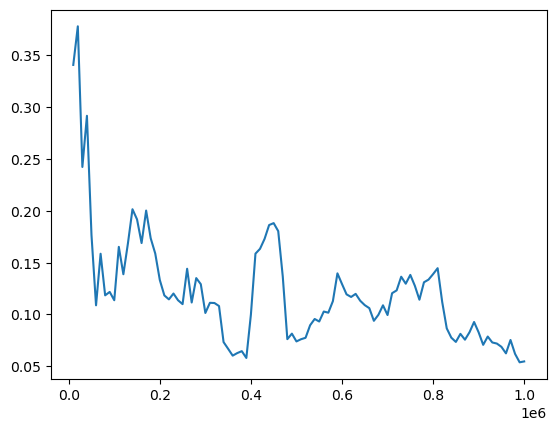

In [454]:
plt.plot(sel_array_foreground,rms_array_foreground)

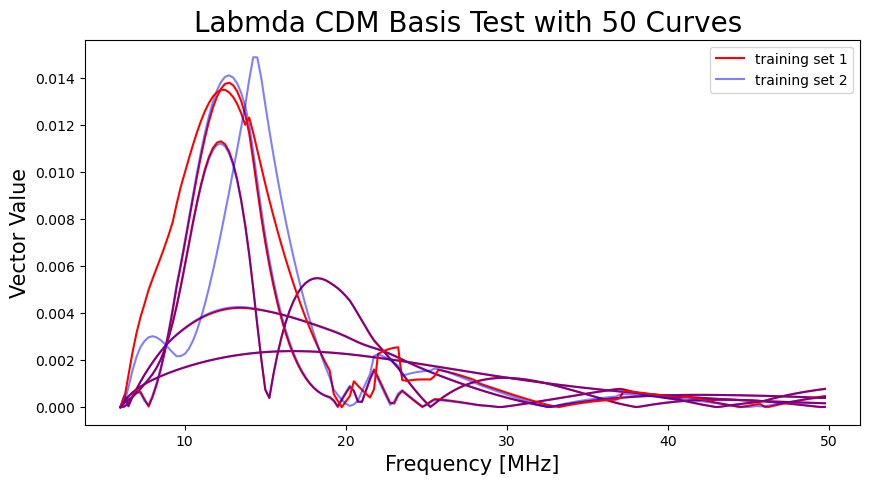

In [394]:
plt.figure(figsize=(10, 5))
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red",label="training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5,label="training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5)
plt.title(f"Labmda CDM Basis Test with {sel} Curves ",fontsize=20)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)
plt.legend()

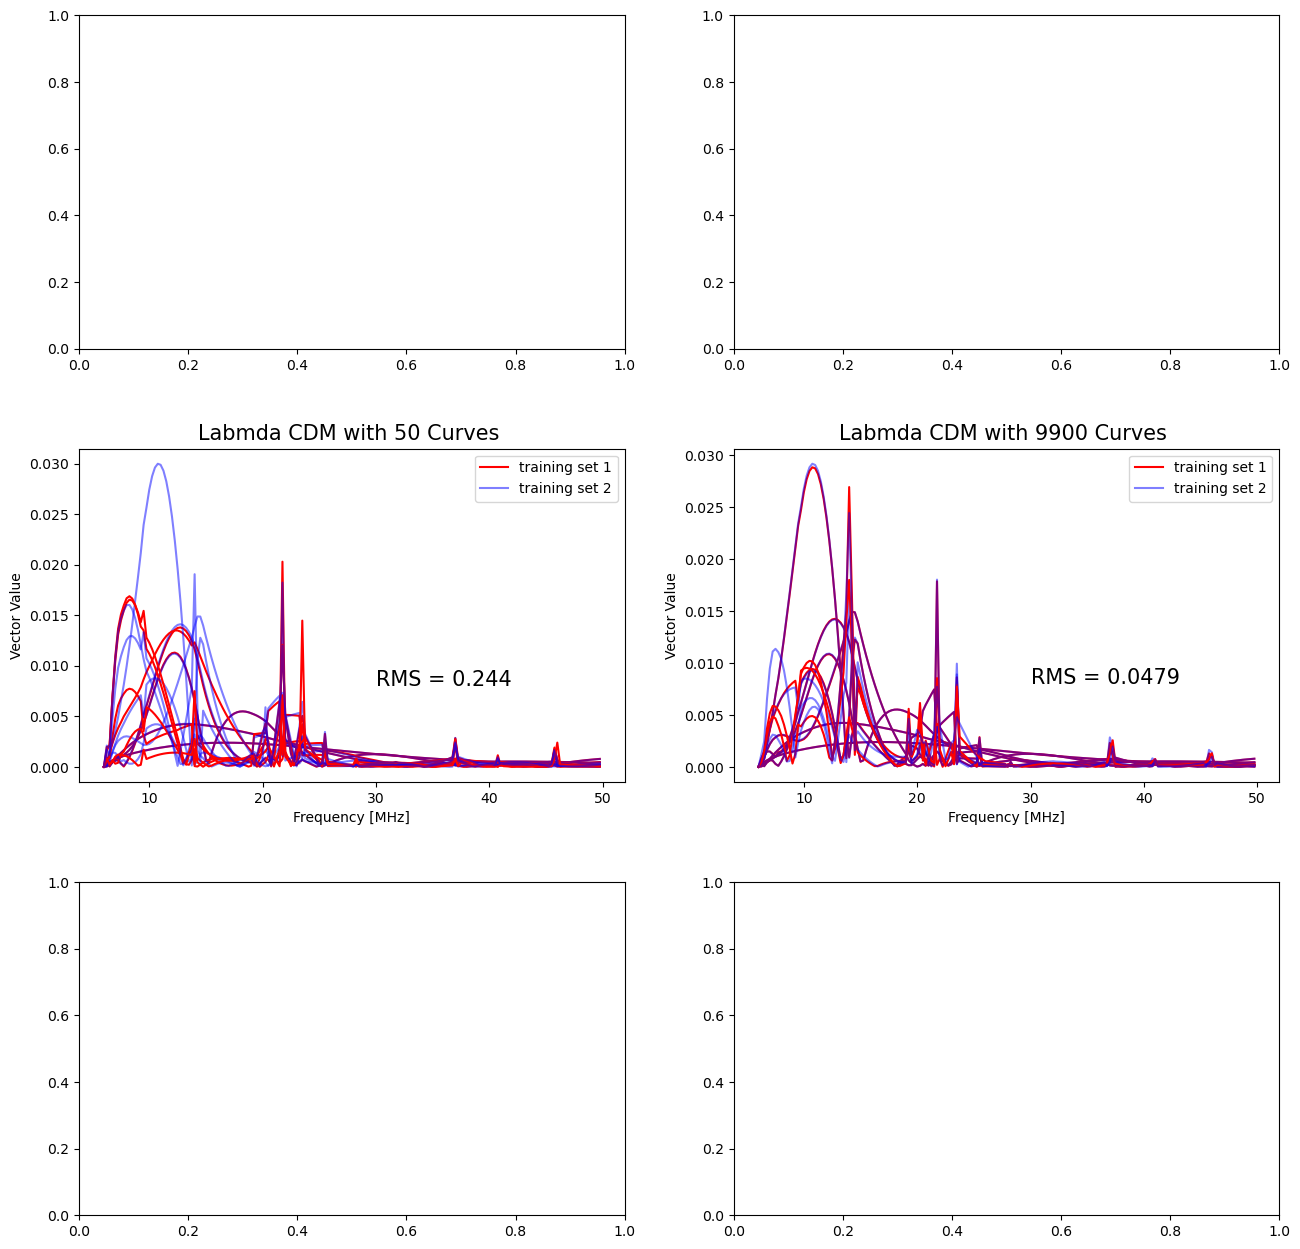

In [432]:


fig, ax = plt.subplots(3,2,figsize=(15, 15))

plt.subplot(3,2,1)



plt.subplot(3,2,2)


plt.subplot(3,2,3)
rms = 0
for n in range(10):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1_100.basis[n]),c="red",label="training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2_100.basis[n]),c="blue",alpha=0.5,label="training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1_100.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2_100.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(signal_basis_CDM1_100.basis[n]),np.abs(signal_basis_CDM2_100.basis[n]))
plt.title(f"Labmda CDM with {sel2} Curves ",fontsize=15)
plt.ylabel("Vector Value",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)

plt.text(30,0.008,f"RMS = {rms:.3f}",fontsize=15)
plt.legend()


plt.subplot(3,2,4)
rms = 0
for n in range(10):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red",label="training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5,label="training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(signal_basis_CDM1.basis[n]),np.abs(signal_basis_CDM2.basis[n]))
plt.title(f"Labmda CDM with {sel} Curves ",fontsize=15)
plt.ylabel("Vector Value",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)

plt.text(30,0.008,f"RMS = {rms:.4f}",fontsize=15)
plt.legend()


plt.subplot(3,2,4)

plt.subplot(3,2,5)


plt.subplot(3,2,6)



plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.3)

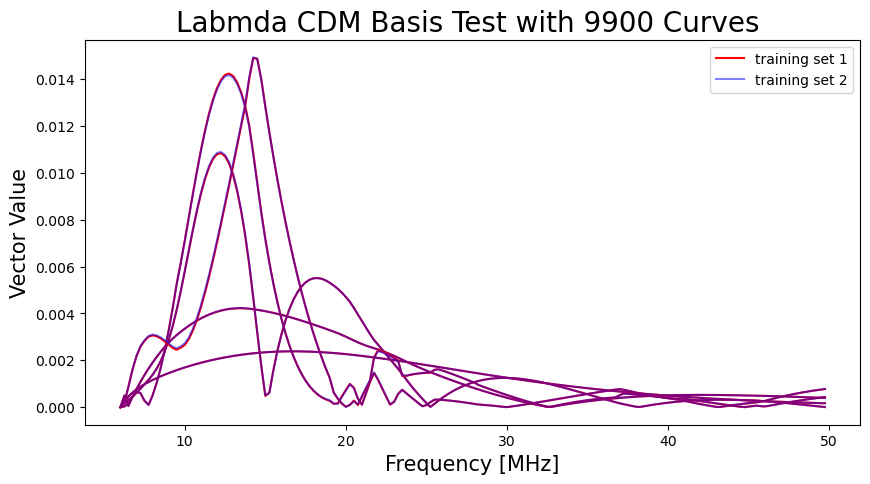

In [431]:
# Lambda CDM basis test with 1000 curves

plt.figure(figsize=(10, 5))
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red",label="training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5,label="training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5)
plt.title(f"Labmda CDM Basis Test with {sel} Curves ",fontsize=20)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)
plt.legend()
# plt.savefig(save_path+"CDM_basis_test_1000")

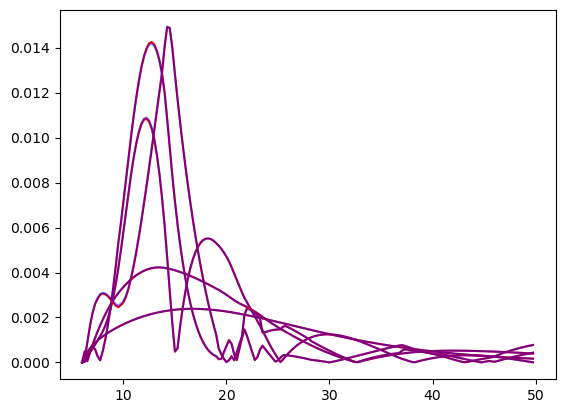

In [361]:
for n in range(5):
    plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red")
    plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5)

0.0007979816464461128

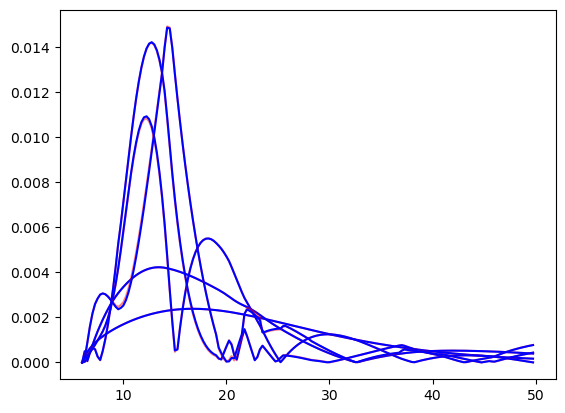

In [318]:
for n in range(5):    
    plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red",alpha=0.5)
    plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue")

Text(0.5, 1.0, 'Foreground Basis Test')

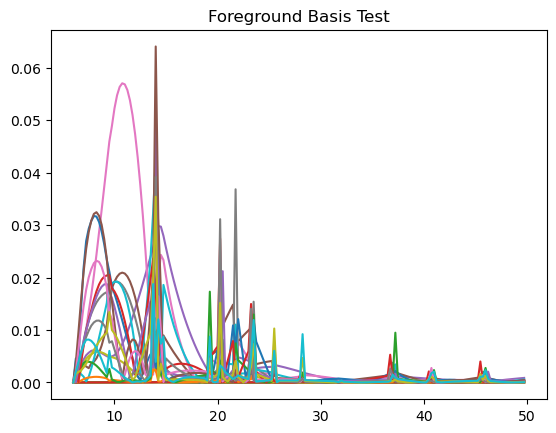

In [355]:
# foreground basis
for n in range(N_vectors):
    plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]-signal_basis_CDM2.basis[n]))
plt.title("Foreground Basis Test")

In [ ]:
Nsel = 50 # The index to go to for your selection of the training sets
ERB_training_set_selection = py21cmsig.ERB_training_set(frequencies,parameters_ERB,N)[0]
signal_training_set = ERB_training_set
noise_level = sigT(sim_data,dnu,dt) 
signal_training_set_array = copy.deepcopy(signal_training_set)
signal_basis = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

array([[2.94735840e-02, 2.78578267e-02, 2.46141038e-02, 2.99325096e-02,
        2.93865189e-02, 2.86669955e-02, 2.18360984e-02, 2.44129015e-02,
        3.23558504e-02, 2.70576262e-02],
       [6.82608829e-03, 6.40788396e-03, 6.04804019e-03, 7.25369552e-03,
        6.43426933e-03, 5.51083518e-03, 6.15018630e-03, 5.23979048e-03,
        4.58206538e-03, 6.17620355e-03],
       [5.00000000e+01, 1.00000000e+02, 2.50000000e+02, 5.00000000e+02,
        7.50000000e+02, 1.00000000e+03, 2.50000000e+03, 5.00000000e+03,
        7.50000000e+03, 1.00000000e+04]])

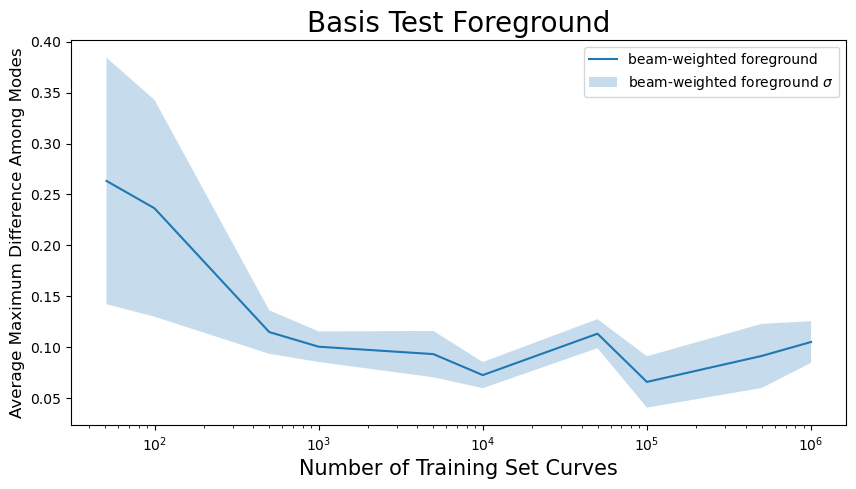

In [947]:
plt.figure(figsize=(10, 5))
plt.plot(average_diff_num_foreground[2], average_diff_num_foreground[0]  ,label = "beam-weighted foreground")
plt.fill_between(average_diff_num_foreground[2], average_diff_num_foreground[0]+average_diff_num_foreground[1]  ,\
    average_diff_num_foreground[0]-average_diff_num_foreground[1]  ,label = r"beam-weighted foreground $\sigma$",alpha=0.25)
plt.title("Basis Test Foreground",fontsize=20)
plt.xlabel("Number of Training Set Curves",fontsize="15")
plt.ylabel("Average Maximum Difference Among Modes",fontsize="12")
plt.xscale("log")
plt.legend()
plt.savefig(save_path+"basis_test_fg_not_using")

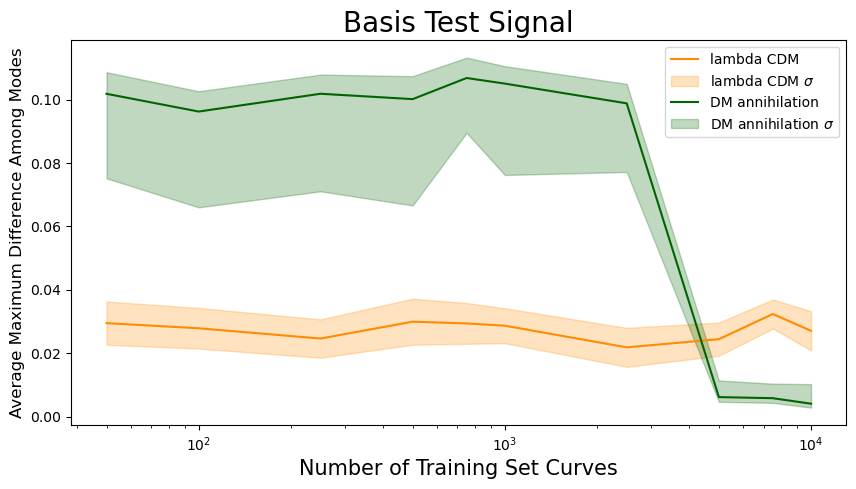

In [946]:
plt.figure(figsize=(10, 5))
plt.plot(average_diff_num_lambdaCDM[2], average_diff_num_lambdaCDM[0]  ,label = "lambda CDM",color="darkorange")
plt.fill_between(average_diff_num_lambdaCDM[2], average_diff_num_lambdaCDM[0]+average_diff_num_lambdaCDM[1],\
    average_diff_num_lambdaCDM[0]-average_diff_num_lambdaCDM[1]  ,label = r"lambda CDM $\sigma$",alpha=0.25,color="darkorange")
plt.plot(average_diff_num_DMAN[2], average_diff_num_DMAN[0]  ,label = "DM annihilation",color="darkgreen")
plt.fill_between(average_diff_num_DMAN[2], average_diff_num_DMAN[0]+average_diff_num_lambdaCDM[1],\
    average_diff_num_DMAN[0]-average_diff_num_DMAN[1]  ,label = r"DM annihilation $\sigma$",alpha=0.25,color="darkgreen")
plt.title("Basis Test Signal",fontsize=20)
plt.xlabel("Number of Training Set Curves",fontsize="15")
plt.ylabel("Average Maximum Difference Among Modes",fontsize="12")
plt.xscale("log")
plt.legend()
plt.savefig(save_path+"basis_test_signals_not_using")

## Example Signal Extraction

  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10369.11it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 154.15it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 500/500 [00:02<00:00, 220.88it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 2/2 [00:00<00:00, 10965.50it/s]


[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.42275312e-02]]
[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.422

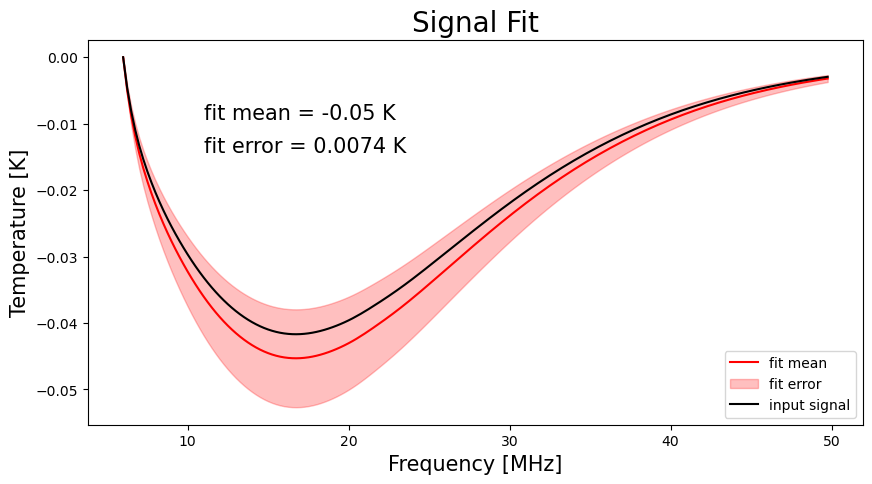

In [ ]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = labmdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=30,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,30)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter2.sizes['Foreground']
num_signal_terms = fitter2.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter2.chi_squared} Chi Squared")
print(f"{fitter2.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")

plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
plt.savefig(save_path+"Example_extraction")

In [49]:
curves_100

<HDF5 dataset "beam_weighted_curves": shape (100, 176), type "<f8">

## Bias (Going to Need to Cook)


In [5]:
# # This creates your 100 random beam-weighted foregrounds
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground

# # signal_model = signal_model_set[signal][Nsim*i+nsim]

# ## Interpolate the varied beams to match the rest of the data
# varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
# for n in range(len(varied_regolith_training_set_raw)):
#     beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#     varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
# Nb = 10 # number of beams in the beam training set
# exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                             custom_parameter_range,show_parameter_ranges=False)

# BTS_curves = exp_test[0]
# BTS_params = exp_test[1]
# beam_sky_training_set = beams[:,5:,:]
# beam_sky_training_set_params = varied_regolith_training_set_raw_params
# raw_beam_weighted_sky_maps = raw_sky_maps
# Nfg = 10
# determine_parameter_range = True
# new_FG_parameter_mean = None
# foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                     beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                         define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)

# # plots the 100 random bwfg
# for n in range(100):
#     plt.plot((foreground_run[3][n]-simulation_test_beam[0])/simulation_test_beam[0])

# new_parameter_mean = np.zeros((n_regions,3))
# fg_range_array_random_10 = np.zeros((n_regions,6))
# foreground_parameter_variation = np.array(parameter_variation)
# for r in range(n_regions):
#     new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#     # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#     fg_range_array_random_10[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#     fg_range_array_random_10[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


###This creates a training set for each of the randomly created beam-weighted foregrounds

# HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","w")
# hdf5.create_dataset("beam_weighted_curves",data=foreground_run[3])
# hdf5.create_dataset("beam_weighted_parameters",data=foreground_run[4])
# hdf5.close()
# End of HDF5 data saving
Nb = 10
Nfg=10
# # # ## HDF5 loading of 100 bw foreground
# # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# # curves_100 = hdf5["beam_weighted_curves"]
# # curves_100_params = hdf5["beam_weighted_parameters"]
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]
# # when we made curves 100, we were willing to do 100 foregrounds, but now I realize that takes too much data
# # curves_10 = curves_100[[0,11,22,33,44,55,66,77,88,99]]  
# # curves_10_params = curves_100_params[[0,11,22,33,44,55,66,77,88,99]]  
# ## HDF5 loading end

custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
custom_parameter_range_variation = [0.000025, 0.00001,0.00001]
parameter_variation = [0.0000005,0.00000025,0.0000005]  

custom_parameter_range_array = np.zeros((Nb,3,2))
foreground_means = np.zeros((Nfg,n_regions,3))
for n in range(Nfg):
    for r in range(n_regions):
        foreground_means[n][r] = curves_100_params[n][r*3:r*3+3]

for n in range(Nb):
    custom_parameter_range_array[n]=[[curves_100_params[n*10][15]-curves_100_params[n*10][15]*custom_parameter_range_variation[0],curves_100_params[n*10][15]+curves_100_params[n*10][15]*custom_parameter_range_variation[0]],\
                                [curves_100_params[n*10][16]-curves_100_params[n*10][16]*custom_parameter_range_variation[1],curves_100_params[n*10][16]+curves_100_params[n*10][16]*custom_parameter_range_variation[1]],\
                                [curves_100_params[n*10][17]-curves_100_params[n*10][17]*custom_parameter_range_variation[2],curves_100_params[n*10][17]+curves_100_params[n*10][16]*custom_parameter_range_variation[2]]]

dt = 10000*3600  # integration time
N = 100000  # number of curves in the training set
Nb = int(np.sqrt(N))
Nfg = int(np.sqrt(N))
curves_100_training_sets = np.zeros((len(curves_100),Nfg*Nb,len(frequencies)))
curves_100_training_set_parameters = np.zeros((len(curves_100),Nfg*Nb,len(foreground_run[4][0])))

for nb,beam_params in enumerate(custom_parameter_range_array):
    for nfg,mean in enumerate(foreground_means):
## Creates a foreground for the simulation:

    # For making a random foreground

    ## Interpolate the varied beams to match the rest of the data
        custom_parameter_range = beam_params
        parameter_variation = [0.0000005,0.00000025,0.0000005] 
        varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
        for n in range(len(varied_regolith_training_set_raw)):
            beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
            varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
        Nb = int(np.sqrt(N)) # number of beams in the beam training set
        exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                                    custom_parameter_range,show_parameter_ranges=False)

        BTS_curves = exp_test[0]
        BTS_params = exp_test[1]
        beam_sky_training_set = beams[:,5:,:]
        beam_sky_training_set_params = varied_regolith_training_set_raw_params
        raw_beam_weighted_sky_maps = raw_sky_maps
        Nfg = int(np.sqrt(N))
        determine_parameter_range = False
        new_FG_parameter_mean = mean
        foreground_run_ts = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                            beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
                                                define_parameter_mean=True,parameter_mean=new_FG_parameter_mean)

        new_parameter_mean = np.zeros((n_regions,3))
        fg_range_array = np.zeros((n_regions,6))
        foreground_parameter_variation = np.array(parameter_variation)
        for r in range(n_regions):
            new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
            # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
            fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
            fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
            fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
            fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
            fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
            fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

        curves_100_training_sets[nfg+len(foreground_means)*nb] = foreground_run_ts[3]
        curves_100_training_set_parameters[nfg+len(foreground_means)*nb] = foreground_run_ts[4]

# HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts_100000","w")
hdf5.create_dataset("curves_training_set",data=curves_100_training_sets)
hdf5.create_dataset("curves_training_set_parameters",data=curves_100_training_set_parameters)
hdf5.close()
# End of HDF5 data saving

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","r")
# curves_10_training_sets = hdf5["curves_training_set"]
# curves_10_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# HDF5 loading of 100 bw foreground training sets (1,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts_100000","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# Curves array is shaped as follows:
# one entry per signal model (1 fiducial + 5 exotic)
# one entry per varied simulation (Nsim)
# 5 entries for different data: 0: full simulation, 1: only the signal, 2: only the foreground, 3: only the noise, 4: simulation without noise
# then the frequency array

Nsim = 1000
signal_models = ["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]
signal_model_set = {"lambdaCDM": lambdaCDM_training_set, "DMAN": DMAN_training_set, "DMD": DMD_training_set, "EDE": EDE_training_set, "ERB": ERB_training_set, "MCDM": MCDM_training_set}
signal_parameter_set = {"lambdaCDM": lambdaCDM_training_set_params, "DMAN": DMAN_training_set_params, "DMD": DMD_training_set_params, "EDE": EDE_training_set_params, "ERB": ERB_training_set_params, "MCDM": MCDM_training_set_params}
simulation_curves_array = np.zeros((Nsim*len(signal_models),5,len(frequencies))) 
simulation_parameters_array = {}

# these expanded curves make working with the signal models a bit easier
curves_100_expanded = curves_100
for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
        curves_100_expanded = np.concatenate((curves_100_expanded,curves_100),axis=0)

curves_100_params_expanded = curves_100_params
for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
        curves_100_params_expanded = np.concatenate((curves_100_params_expanded,curves_100_params),axis=0)

for i,signal in enumerate(signal_models): 
    for nsim,bwfg,par in zip(range(Nsim),curves_100_expanded,curves_100_params_expanded):
        signal_model = signal_model_set[signal][Nsim*i+nsim]
        foreground_for_sim = bwfg
        parameters_for_sim = par

# Our simulation function
        simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

        simulation_curves_array[Nsim*i+nsim][0] = simulation_test_beam[0]
        simulation_curves_array[Nsim*i+nsim][1] = simulation_test_beam[1]
        simulation_curves_array[Nsim*i+nsim][2] = simulation_test_beam[2]
        simulation_curves_array[Nsim*i+nsim][3] = simulation_test_beam[3]
        simulation_curves_array[Nsim*i+nsim][4] = simulation_test_beam[4]

        simulation_parameters_array[Nsim*i+nsim] = {"bwfg": parameters_for_sim, "signal": signal_parameter_set[signal][Nsim*i+nsim]}


Nsim_tot = len(simulation_curves_array)
bias_scores = np.zeros((len(signal_models),Nsim))

for si,s in enumerate(signal_models):
        for n in tqdm(range (Nsim)):

#### Pylinex Fit #####
                foreground_training_set_array = curves_100_training_sets[n % 100]  # this index convention only works if there are 10 foregrounds and some multiple of 100 signals (such as 1000)
                signal_model_number = s  # Only works when you have 1000 signals of the same model
                model = s
                print(model)
                sig_training_set = signal_model_set[model]
                IC = "DIC"
                sim = simulation_curves_array[n+Nsim*si]
                sim_data = sim[0]
                true_curve = sim[1]
                noise_level = sigT(sim_data,dnu,dt)
                foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
                signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
                temperatures = sim_data
                basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
                quantity = AttributeQuantity(IC)
                dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
                # priors = {"Signal_prior" : signal_basis.gaussian_prior}
                meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
                fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
                num_foreground_terms = fitter2.sizes['Foreground']
                num_signal_terms = fitter2.sizes['Signal']
                print(f"foreground_terms = {num_foreground_terms}")
                print(f"signal_terms = {num_signal_terms}")
                bias_scores[si][n] = fitter2.subbasis_bias_statistic("Signal",true_curve,norm_by_dof=True)
                print(fitter2.subbasis_bias_statistic("Signal",true_curve,norm_by_dof=True))

        
# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_100000","w")
# hdf5.create_dataset("bias_scores",data=bias_scores)
# hdf5.close()
# End of HDF5 data saving
        

        # print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
        # print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
        # print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
        # print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
        # # print(f"{fitter2.log_evidence} log evidence")
        # print(f"{fitter2.chi_squared} Chi Squared")
        # print(f"{fitter2.psi_squared} Psi Squared")
        # pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
        # print(f"True {pearsonr}")

                # plt.figure(figsize=(10, 5))
                # plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
                # plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
                # plt.title("Signal Fit",fontsize=20)
                # plt.xlabel("Frequency [MHz]",fontsize="15")
                # plt.ylabel("Temperature [K]",fontsize="15")
                # plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
                # plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
                # plt.plot(frequencies,sim[1],label="input signal",c="black")
                # plt.legend()
                # plt.show()
        # plt.savefig(save_path+"Example_extraction")


  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 316/316 [00:00<00:00, 411.68it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 228.72it/s]


KeyboardInterrupt: 

In [6]:
#this is alternative code for creating a single very large training set

custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
custom_parameter_range_variation = [0.000025, 0.00001,0.00001]
parameter_variation = [0.0000005,0.00000025,0.0000005]  
Nfg=10
Nb=10
custom_parameter_range_array = np.zeros((Nb,3,2))
foreground_means = np.zeros((Nfg,n_regions,3))
for n in range(Nfg):
    for r in range(n_regions):
        foreground_means[n][r] = curves_100_params[n][r*3:r*3+3]

for n in range(Nb):
    custom_parameter_range_array[n]=[[curves_100_params[n*10][15]-curves_100_params[n*10][15]*custom_parameter_range_variation[0],curves_100_params[n*10][15]+curves_100_params[n*10][15]*custom_parameter_range_variation[0]],\
                                [curves_100_params[n*10][16]-curves_100_params[n*10][16]*custom_parameter_range_variation[1],curves_100_params[n*10][16]+curves_100_params[n*10][16]*custom_parameter_range_variation[1]],\
                                [curves_100_params[n*10][17]-curves_100_params[n*10][17]*custom_parameter_range_variation[2],curves_100_params[n*10][17]+curves_100_params[n*10][16]*custom_parameter_range_variation[2]]]

dt = 10000*3600  # integration time
N = 5000000  # number of curves in the training set
Nb = int(np.sqrt(N))
Nfg = int(np.sqrt(N))
curves_100_training_sets = np.zeros((Nfg*Nb,len(frequencies)))
curves_100_training_set_parameters = np.zeros((Nfg*Nb,len(foreground_run[4][0])))

nb=0
beam_params = custom_parameter_range_array[0]
nfg=0
mean = foreground_means[0]
## Creates a foreground for the simulation:

# For making a random foreground

## Interpolate the varied beams to match the rest of the data
custom_parameter_range = beam_params
parameter_variation = [0.0000005,0.00000025,0.0000005] 
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = int(np.sqrt(N)) # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                            custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
Nfg = int(np.sqrt(N))
determine_parameter_range = False
new_FG_parameter_mean = mean
foreground_run_ts = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
                                        define_parameter_mean=True,parameter_mean=new_FG_parameter_mean)

new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

curves_100_training_sets_5mil = foreground_run_ts[3]
curves_100_training_set_parameters_5mil = foreground_run_ts[4]

# HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_single_sims_ts_5mil_2","w")
hdf5.create_dataset("curves_training_set",data=curves_100_training_sets_5mil)
hdf5.create_dataset("curves_training_set_parameters",data=curves_100_training_set_parameters_5mil)
hdf5.close()
# End of HDF5 data saving

100%|██████████| 2236/2236 [00:38<00:00, 58.47it/s]


[5e-07, 2.5e-07, 5e-07]


In [70]:
## Code for running my own bias function

bias_function = lambda frequencies,model_curve, fit_curve, noise: np.sqrt(1/len(frequencies)*(((model_curve-fit_curve)**2)/noise**2).sum())

In [72]:
bias_function (frequencies,sim[1],fitter2.subbasis_channel_mean("Signal"),fitter2.subbasis_channel_error("Signal"))

1.078141705431645

In [78]:
fitter2.bias_statistic/170

0.9454562710156209

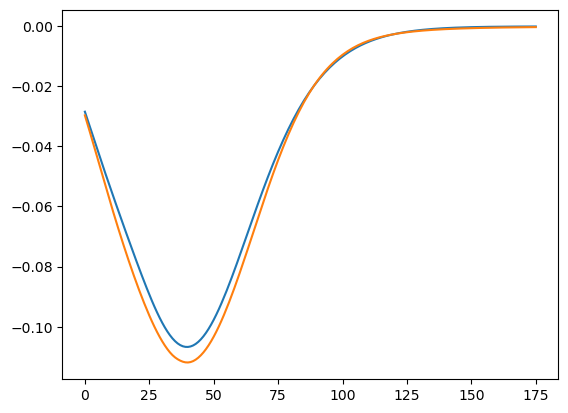

In [69]:
plt.plot(fitter2.subbasis_channel_mean("Signal"))
plt.plot(sim[1])

In [4]:
### this is a separate cell for running the 5mil single fg training set.

# # This creates your 100 random beam-weighted foregrounds
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground

# # signal_model = signal_model_set[signal][Nsim*i+nsim]

# ## Interpolate the varied beams to match the rest of the data
# varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
# for n in range(len(varied_regolith_training_set_raw)):
#     beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#     varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
# Nb = 10 # number of beams in the beam training set
# exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                             custom_parameter_range,show_parameter_ranges=False)

# BTS_curves = exp_test[0]
# BTS_params = exp_test[1]
# beam_sky_training_set = beams[:,5:,:]
# beam_sky_training_set_params = varied_regolith_training_set_raw_params
# raw_beam_weighted_sky_maps = raw_sky_maps
# Nfg = 10
# determine_parameter_range = True
# new_FG_parameter_mean = None
# foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                     beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                         define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)

# # plots the 100 random bwfg
# for n in range(100):
#     plt.plot((foreground_run[3][n]-simulation_test_beam[0])/simulation_test_beam[0])

# new_parameter_mean = np.zeros((n_regions,3))
# fg_range_array_random_10 = np.zeros((n_regions,6))
# foreground_parameter_variation = np.array(parameter_variation)
# for r in range(n_regions):
#     new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#     # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#     fg_range_array_random_10[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#     fg_range_array_random_10[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


###This creates a training set for each of the randomly created beam-weighted foregrounds

# HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","w")
# hdf5.create_dataset("beam_weighted_curves",data=foreground_run[3])
# hdf5.create_dataset("beam_weighted_parameters",data=foreground_run[4])
# hdf5.close()
# # End of HDF5 data saving
# Nb = 10
# Nfg=10
# # # # ## HDF5 loading of 100 bw foreground
# # # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# # # curves_100 = hdf5["beam_weighted_curves"]
# # # curves_100_params = hdf5["beam_weighted_parameters"]
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# curves_100 = hdf5["beam_weighted_curves"]
# curves_100_params = hdf5["beam_weighted_parameters"]
# # when we made curves 100, we were willing to do 100 foregrounds, but now I realize that takes too much data
# # curves_10 = curves_100[[0,11,22,33,44,55,66,77,88,99]]  
# # curves_10_params = curves_100_params[[0,11,22,33,44,55,66,77,88,99]]  
# ## HDF5 loading end

# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# custom_parameter_range_variation = [0.000025, 0.00001,0.00001]
# parameter_variation = [0.0000005,0.00000025,0.0000005]  

# custom_parameter_range_array = np.zeros((Nb,3,2))
# foreground_means = np.zeros((Nfg,n_regions,3))
# for n in range(Nfg):
#     for r in range(n_regions):
#         foreground_means[n][r] = curves_100_params[n][r*3:r*3+3]

# for n in range(Nb):
#     custom_parameter_range_array[n]=[[curves_100_params[n*10][15]-curves_100_params[n*10][15]*custom_parameter_range_variation[0],curves_100_params[n*10][15]+curves_100_params[n*10][15]*custom_parameter_range_variation[0]],\
#                                 [curves_100_params[n*10][16]-curves_100_params[n*10][16]*custom_parameter_range_variation[1],curves_100_params[n*10][16]+curves_100_params[n*10][16]*custom_parameter_range_variation[1]],\
#                                 [curves_100_params[n*10][17]-curves_100_params[n*10][17]*custom_parameter_range_variation[2],curves_100_params[n*10][17]+curves_100_params[n*10][16]*custom_parameter_range_variation[2]]]

# dt = 10000*3600  # integration time
# N = 100000  # number of curves in the training set
# Nb = int(np.sqrt(N))
# Nfg = int(np.sqrt(N))
# curves_100_training_sets = np.zeros((len(curves_100),Nfg*Nb,len(frequencies)))
# curves_100_training_set_parameters = np.zeros((len(curves_100),Nfg*Nb,len(foreground_run[4][0])))

# for nb,beam_params in enumerate(custom_parameter_range_array):
#     for nfg,mean in enumerate(foreground_means):
# ## Creates a foreground for the simulation:

#     # For making a random foreground

#     ## Interpolate the varied beams to match the rest of the data
#         custom_parameter_range = beam_params
#         parameter_variation = [0.0000005,0.00000025,0.0000005] 
#         varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
#         for n in range(len(varied_regolith_training_set_raw)):
#             beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#             varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
#         Nb = int(np.sqrt(N)) # number of beams in the beam training set
#         exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                                     custom_parameter_range,show_parameter_ranges=False)

#         BTS_curves = exp_test[0]
#         BTS_params = exp_test[1]
#         beam_sky_training_set = beams[:,5:,:]
#         beam_sky_training_set_params = varied_regolith_training_set_raw_params
#         raw_beam_weighted_sky_maps = raw_sky_maps
#         Nfg = int(np.sqrt(N))
#         determine_parameter_range = False
#         new_FG_parameter_mean = mean
#         foreground_run_ts = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                             beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                                 define_parameter_mean=True,parameter_mean=new_FG_parameter_mean)

#         new_parameter_mean = np.zeros((n_regions,3))
#         fg_range_array = np.zeros((n_regions,6))
#         foreground_parameter_variation = np.array(parameter_variation)
#         for r in range(n_regions):
#             new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#             # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#             fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#             fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#             fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#             fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#             fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#             fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

#         curves_100_training_sets[nfg+len(foreground_means)*nb] = foreground_run_ts[3]
#         curves_100_training_set_parameters[nfg+len(foreground_means)*nb] = foreground_run_ts[4]

# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts_100000","w")
# hdf5.create_dataset("curves_training_set",data=curves_100_training_sets)
# hdf5.create_dataset("curves_training_set_parameters",data=curves_100_training_set_parameters)
# hdf5.close()
# # End of HDF5 data saving

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","r")
# curves_10_training_sets = hdf5["curves_training_set"]
# curves_10_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# HDF5 loading of 1 bw foreground training sets (5mil curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_single_sims_ts_5mil","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# foreground_basis = TrainedBasis(training_set=curves_100_training_sets, num_basis_vectors=100,error=noise_level)

# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/trained_basis_5mil","w")
# hdf5.create_dataset("foreground_basis",data=foreground_basis)
# hdf5.close()
# # End of HDF5 data saving

# Curves array is shaped as follows:
# one entry per signal model (1 fiducial + 5 exotic)
# one entry per varied simulation (Nsim)
# 5 entries for different data: 0: full simulation, 1: only the signal, 2: only the foreground, 3: only the noise, 4: simulation without noise
# then the frequency array

Nsim = 1000
signal_models = ["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]
signal_model_set = {"lambdaCDM": lambdaCDM_training_set, "DMAN": DMAN_training_set, "DMD": DMD_training_set, "EDE": EDE_training_set, "ERB": ERB_training_set, "MCDM": MCDM_training_set}
signal_parameter_set = {"lambdaCDM": lambdaCDM_training_set_params, "DMAN": DMAN_training_set_params, "DMD": DMD_training_set_params, "EDE": EDE_training_set_params, "ERB": ERB_training_set_params, "MCDM": MCDM_training_set_params}
simulation_curves_array = np.zeros((Nsim*len(signal_models),5,len(frequencies))) 
simulation_parameters_array = {}

Nb = 10
Nfg=10
# # # ## HDF5 loading of 100 bw foreground
# # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# # curves_100 = hdf5["beam_weighted_curves"]
# # curves_100_params = hdf5["beam_weighted_parameters"]
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]

noise_level = sigT(curves_100[0],dnu,dt)

hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_single_sims_ts_5mil","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# foreground_basis = TrainedBasis(training_set=curves_100_training_sets, num_basis_vectors=100,error=noise_level)

# # these expanded curves make working with the signal models a bit easier
# curves_100_expanded = curves_100
# for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
#         curves_100_expanded = np.concatenate((curves_100_expanded,curves_100),axis=0)

# curves_100_params_expanded = curves_100_params
# for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
#         curves_100_params_expanded = np.concatenate((curves_100_params_expanded,curves_100_params),axis=0)

foreground_for_sim = curves_100[0]
parameters_for_sim = curves_100_params[0]
for i,signal in enumerate(signal_models): 
    bwfg = curves_100[0]
    par = curves_100_params[0]
    for nsim in range(Nsim):
        signal_model = signal_model_set[signal][Nsim*i+nsim]

# Our simulation function
        simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

        simulation_curves_array[Nsim*i+nsim][0] = simulation_test_beam[0]
        simulation_curves_array[Nsim*i+nsim][1] = simulation_test_beam[1]
        simulation_curves_array[Nsim*i+nsim][2] = simulation_test_beam[2]
        simulation_curves_array[Nsim*i+nsim][3] = simulation_test_beam[3]
        simulation_curves_array[Nsim*i+nsim][4] = simulation_test_beam[4]

        simulation_parameters_array[Nsim*i+nsim] = {"bwfg": parameters_for_sim, "signal": signal_parameter_set[signal][Nsim*i+nsim]}


Nsim_tot = len(simulation_curves_array)
bias_scores = np.zeros((len(signal_models),Nsim))

for si,s in enumerate(signal_models):
        for n in tqdm(range (Nsim)):

#### Pylinex Fit #####
                signal_model_number = s  # Only works when you have 1000 signals of the same model
                model = s
                print(model)
                sig_training_set = signal_model_set[model]
                IC = "DIC"
                sim = simulation_curves_array[n+Nsim*si]
                sim_data = sim[0]
                true_curve = sim[1]
                noise_level = sigT(sim_data,dnu,dt)
                signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
                temperatures = sim_data
                basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
                quantity = AttributeQuantity(IC)
                dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
                # priors = {"Signal_prior" : signal_basis.gaussian_prior}
                meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
                fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
                num_foreground_terms = fitter2.sizes['Foreground']
                num_signal_terms = fitter2.sizes['Signal']
                print(f"foreground_terms = {num_foreground_terms}")
                print(f"signal_terms = {num_signal_terms}")
                bias_scores[si][n] = fitter2.subbasis_bias_statistic("Signal",true_curve,norm_by_dof=True)
                print(fitter2.subbasis_bias_statistic("Signal",true_curve,norm_by_dof=True))

        
# # HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_5mil_1fg","w")
hdf5.create_dataset("bias_scores",data=bias_scores)
hdf5.close()
# End of HDF5 data saving
        

        # print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
        # print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
        # print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
        # print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
        # # print(f"{fitter2.log_evidence} log evidence")
        # print(f"{fitter2.chi_squared} Chi Squared")
        # print(f"{fitter2.psi_squared} Psi Squared")
        # pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
        # print(f"True {pearsonr}")

                # plt.figure(figsize=(10, 5))
                # plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
                # plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
                # plt.title("Signal Fit",fontsize=20)
                # plt.xlabel("Frequency [MHz]",fontsize="15")
                # plt.ylabel("Temperature [K]",fontsize="15")
                # plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
                # plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
                # plt.plot(frequencies,sim[1],label="input signal",c="black")
                # plt.legend()
                # plt.show()
        # plt.savefig(save_path+"Example_extraction")


  0%|          | 0/1000 [00:00<?, ?it/s]


lambdaCDM


NameError: name 'foreground_basis' is not defined

In [5]:
foreground_basis = TrainedBasis(training_set=curves_100_training_sets[0:4000000], num_basis_vectors=100,error=noise_level)


: 

IndexError: index 6 is out of bounds for axis 0 with size 6

In [60]:
bias_scores.mean()

nan

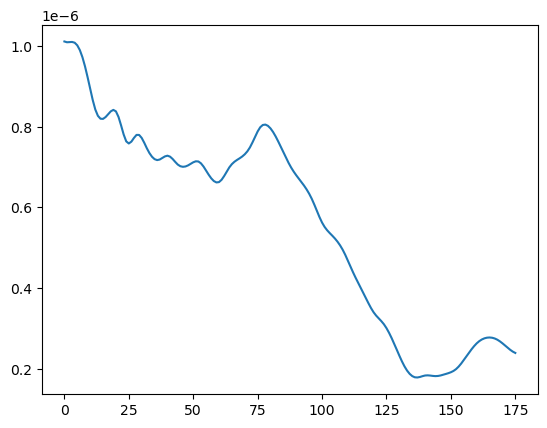

In [20]:
# plt.plot(curves_100[0])
plt.plot((curves_100_training_sets[1000]-curves_100[0])/curves_100[0])

In [4]:
Nb = 10
Nfg=10
# # # ## HDF5 loading of 100 bw foreground
# # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# # curves_100 = hdf5["beam_weighted_curves"]
# # curves_100_params = hdf5["beam_weighted_parameters"]
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]

noise_level = sigT(curves_100[0],dnu,dt)

hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_single_sims_ts_5mil","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

foreground_basis = TrainedBasis(training_set=curves_100_training_sets, num_basis_vectors=100,error=noise_level)

In [12]:
foreground_basis

In [6]:
# # HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/trained_basis_5mil","w")
hdf5.create_dataset("foreground_basis",data=foreground_basis)
hdf5.close()
# # End of HDF5 data saving

ValueError: basis given to Basis class was not 2D. It should be of shape (Nbasis, Nchannel).

IndexError: index 961 is out of bounds for axis 0 with size 961

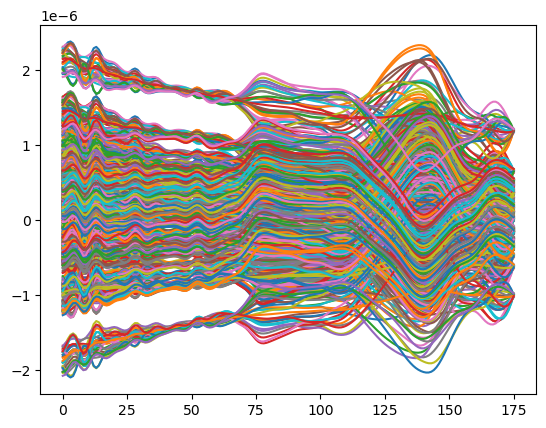

In [102]:
r=10
for n in range(1000):
    plt.plot((curves_100_training_sets[r][n]-curves_100[r])/curves_100[r])

In [54]:
curves_100_training_sets

<HDF5 dataset "curves_training_set": shape (100, 10000, 176), type "<f8">

In [33]:
bias_scores[0]

array([ 1.06677206,  5.67619151,  3.29763236,  2.49467598,  3.40909264,
        1.64793744,  4.49813   , 11.04575828,  3.56624539,  3.43012434])

In [ ]:
# HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores","w")
hdf5.create_dataset("bias_scores",data=bias_scores)
hdf5.close()
# End of HDF5 data saving
        

In [80]:
# cleans the nans from the bias scores. No idea why the nans show up in the first place, but whatever.


data = bias_scores
clean_bias = data[~np.isnan(data)]
super_clean_bias = clean_bias[~np.isinf(clean_bias)] # Keep only finite values

In [81]:
super_clean_bias.mean()

3.8565801769925154

In [116]:
bias_scores[0:9]

array([2.06571818,        nan, 0.74440273, 1.2940818 , 6.41510161,
       8.92647906, 1.47640617, 0.38223466, 1.70062205])

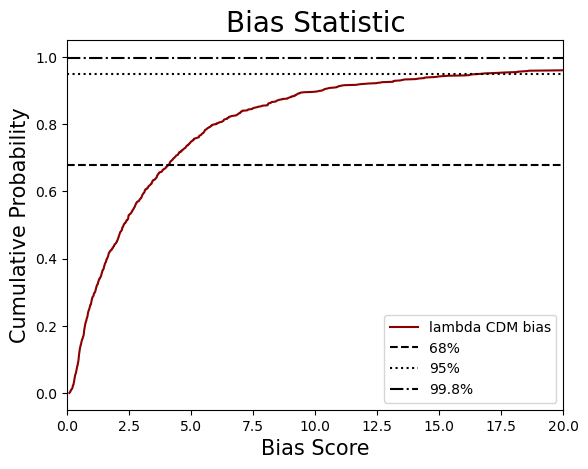

In [59]:
# plt.figure(figsize=(5, 5))
CDM_data = bias_scores[5]
CDM_data.sort()
CDM_std=data.std()
CDM_mean=data.mean()
CDM_range = np.arange(CDM_data.min(),CDM_data.max(),(CDM_data.max()-CDM_data.min())/len(CDM_data))
CDM_CDF = scipy.stats.norm.cdf(CDM_range,CDM_mean,CDM_std)
CDM_cdf_values = np.arange(1, len(CDM_data) + 1) / len(CDM_data)
plt.plot
plt.plot(CDM_data, CDM_cdf_values,label = "lambda CDM bias", c="darkred")
# plt.plot(CDM_range,CDM_CDF,ls="--",c="darkred",label="lambda CDM expected bias")
plt.axhline(0.68,ls="--",c="black",label="68%")
plt.axhline(0.95,ls=":",c="black",label="95%")
plt.axhline(0.998,ls="-.",c="black",label="99.8%")
plt.title("Bias Statistic",fontsize=20)
plt.xlabel("Bias Score",fontsize="15")
plt.ylabel("Cumulative Probability",fontsize="15")
plt.xlim(0,20)
# plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
# plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
plt.savefig(save_path+"Bias_statistic")


### some useful troubleshooting graphs
# N = 99
# for n in range(10000):
#     plt.plot((curves_100_training_sets[N][n]-curves_100[N])/curves_100[N])

# plt.figure(figsize=(10, 5))
# plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
# plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
# plt.title("Signal Fit",fontsize=20)
# plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.ylabel("Temperature [K]",fontsize="15")
# plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
# plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,sim[1],label="input signal",c="black")
# plt.legend()
# plt.savefig(save_path+"Example_extraction")

# h=60
# for n in range(100):
#     plt.plot((curves_100_training_sets[h][n]-curves_100[1])/curves_100[1])
# plt.plot(sigT(curves_100[h],dnu,dt)/curves_100[h]*10)
# plt.plot(-sigT(curves_100[h],dnu,dt)/curves_100[h]*10)

# K-S test

## SVD Training Set Fit Graph

In [ ]:
# SVD Training Set Fit Graph
## HDF5 loading of 100 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]

## Loaded in signal training sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

## HDF5 loading end
Ncurves = 1000
# lambda CDM SVD test:
CDM_test_sims = np.zeros((Ncurves,len(frequencies)))
CDM_test_fg = np.zeros((Ncurves,len(frequencies)))
CDM_test_sig = np.zeros((Ncurves,len(frequencies)))
CDM_test_noise = np.zeros((Ncurves,len(frequencies)))
CDM_test_nonoise = np.zeros((Ncurves,len(frequencies)))

for n in range(Ncurves):
    random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
    random_index2=int(np.random.random()*len(lambdaCDM_training_set))
    CDM_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[0]
    CDM_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[2]
    CDM_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[1]
    CDM_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[3]
    CDM_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[4]



CDM_foreground_terms = np.zeros((Ncurves))
CDM_signal_terms = np.zeros((Ncurves))
sig_training_set = lambdaCDM_training_set
sim_curves = CDM_test_sims
for n in tqdm(range (Ncurves)):
#### Pylinex Fit #####
    foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
    sig_training_set
    IC = "DIC"
    sim = simulation_curves_array[n]
    sim_data = sim_curves[n]
    noise_level = sigT(sim_data,dnu,dt)
    foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
    signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
    temperatures = sim_data
    basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
    quantity = AttributeQuantity(IC)
    dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
    # priors = {"Signal_prior" : signal_basis.gaussian_prior}
    meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
    fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
    CDM_foreground_terms[n] = fitter2.sizes['Foreground']
    CDM_signal_terms[n] = fitter2.sizes['Signal']
### End PYLINEX fit

# HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/CDM_SVD_test_data","w")
hdf5.create_dataset("data",data=CDM_test_sims)
hdf5.create_dataset("foreground",data=CDM_test_fg)
hdf5.create_dataset("signal",data=CDM_test_sig)
hdf5.create_dataset("noise",data=CDM_test_noise)
hdf5.create_dataset("data_no_noise",data=CDM_test_nonoise)
hdf5.create_dataset("foreground_terms",data=CDM_foreground_terms)
hdf5.create_dataset("signal_terms",data=CDM_signal_terms)
hdf5.close()
## End of HDF5 data saving

# DMAN SVD test:
DMAN_test_sims = np.zeros((Ncurves,len(frequencies)))
DMAN_test_fg = np.zeros((Ncurves,len(frequencies)))
DMAN_test_sig = np.zeros((Ncurves,len(frequencies)))
DMAN_test_noise = np.zeros((Ncurves,len(frequencies)))
DMAN_test_nonoise = np.zeros((Ncurves,len(frequencies)))

for n in range(Ncurves):
    random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
    random_index2=int(np.random.random()*len(DMAN_training_set))
    DMAN_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[0]
    DMAN_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[2]
    DMAN_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[1]
    DMAN_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[3]
    DMAN_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[4]




DMAN_foreground_terms = np.zeros((Ncurves))
DMAN_signal_terms = np.zeros((Ncurves))
sig_training_set = DMAN_training_set
sim_curves = DMAN_test_sims
for n in tqdm(range (Ncurves)):
#### Pylinex Fit #####
    foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
    sig_training_set
    IC = "DIC"
    sim = simulation_curves_array[n]
    sim_data = sim_curves[n]
    noise_level = sigT(sim_data,dnu,dt)
    foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
    signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
    temperatures = sim_data
    basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
    quantity = AttributeQuantity(IC)
    dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
    # priors = {"Signal_prior" : signal_basis.gaussian_prior}
    meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
    fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
    DMAN_foreground_terms[n] = fitter2.sizes['Foreground']
    DMAN_signal_terms[n] = fitter2.sizes['Signal']
### End PYLINEX fit

    # HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_SVD_test_data","w")
hdf5.create_dataset("data",data=DMAN_test_sims)
hdf5.create_dataset("foreground",data=DMAN_test_fg)
hdf5.create_dataset("signal",data=DMAN_test_sig)
hdf5.create_dataset("noise",data=DMAN_test_noise)
hdf5.create_dataset("data_no_noise",data=DMAN_test_nonoise)
hdf5.create_dataset("foreground_terms",data=DMAN_foreground_terms)
hdf5.create_dataset("signal_terms",data=DMAN_signal_terms)
hdf5.close()
## End of HDF5 data saving

# DMD SVD test:
DMD_test_sims = np.zeros((Ncurves,len(frequencies)))
DMD_test_fg = np.zeros((Ncurves,len(frequencies)))
DMD_test_sig = np.zeros((Ncurves,len(frequencies)))
DMD_test_noise = np.zeros((Ncurves,len(frequencies)))
DMD_test_nonoise = np.zeros((Ncurves,len(frequencies)))

for n in range(Ncurves):
    random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
    random_index2=int(np.random.random()*len(DMD_training_set))
    DMD_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[0]
    DMD_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[2]
    DMD_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[1]
    DMD_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[3]
    DMD_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[4]




DMD_foreground_terms = np.zeros((Ncurves))
DMD_signal_terms = np.zeros((Ncurves))
sig_training_set = DMD_training_set
sim_curves = DMD_test_sims
for n in tqdm(range (Ncurves)):
#### Pylinex Fit #####
    foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
    sig_training_set
    IC = "DIC"
    sim = simulation_curves_array[n]
    sim_data = sim_curves[n]
    noise_level = sigT(sim_data,dnu,dt)
    foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
    signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
    temperatures = sim_data
    basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
    quantity = AttributeQuantity(IC)
    dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
    # priors = {"Signal_prior" : signal_basis.gaussian_prior}
    meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
    fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
    DMD_foreground_terms[n] = fitter2.sizes['Foreground']
    DMD_signal_terms[n] = fitter2.sizes['Signal']
### End PYLINEX fit

    # HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_SVD_test_data","w")
hdf5.create_dataset("data",data=DMD_test_sims)
hdf5.create_dataset("foreground",data=DMD_test_fg)
hdf5.create_dataset("signal",data=DMD_test_sig)
hdf5.create_dataset("noise",data=DMD_test_noise)
hdf5.create_dataset("data_no_noise",data=DMD_test_nonoise)
hdf5.create_dataset("foreground_terms",data=DMD_foreground_terms)
hdf5.create_dataset("signal_terms",data=DMD_signal_terms)
hdf5.close()
## End of HDF5 data saving

# MCDM SVD test:
MCDM_test_sims = np.zeros((Ncurves,len(frequencies)))
MCDM_test_fg = np.zeros((Ncurves,len(frequencies)))
MCDM_test_sig = np.zeros((Ncurves,len(frequencies)))
MCDM_test_noise = np.zeros((Ncurves,len(frequencies)))
MCDM_test_nonoise = np.zeros((Ncurves,len(frequencies)))

for n in range(Ncurves):
    random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
    random_index2=int(np.random.random()*len(MCDM_training_set))
    MCDM_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[0]
    MCDM_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[2]
    MCDM_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[1]
    MCDM_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[3]
    MCDM_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[4]




MCDM_foreground_terms = np.zeros((Ncurves))
MCDM_signal_terms = np.zeros((Ncurves))
sig_training_set = MCDM_training_set
sim_curves = MCDM_test_sims
for n in tqdm(range (Ncurves)):
#### Pylinex Fit #####
    foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
    sig_training_set
    IC = "DIC"
    sim = simulation_curves_array[n]
    sim_data = sim_curves[n]
    noise_level = sigT(sim_data,dnu,dt)
    foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
    signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
    temperatures = sim_data
    basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
    quantity = AttributeQuantity(IC)
    dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
    # priors = {"Signal_prior" : signal_basis.gaussian_prior}
    meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
    fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
    MCDM_foreground_terms[n] = fitter2.sizes['Foreground']
    MCDM_signal_terms[n] = fitter2.sizes['Signal']
### End PYLINEX fit

    # HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_SVD_test_data","w")
hdf5.create_dataset("data",data=MCDM_test_sims)
hdf5.create_dataset("foreground",data=MCDM_test_fg)
hdf5.create_dataset("signal",data=MCDM_test_sig)
hdf5.create_dataset("noise",data=MCDM_test_noise)
hdf5.create_dataset("data_no_noise",data=MCDM_test_nonoise)
hdf5.create_dataset("foreground_terms",data=MCDM_foreground_terms)
hdf5.create_dataset("signal_terms",data=MCDM_signal_terms)
hdf5.close()
## End of HDF5 data saving

# EDE SVD test:
EDE_test_sims = np.zeros((Ncurves,len(frequencies)))
EDE_test_fg = np.zeros((Ncurves,len(frequencies)))
EDE_test_sig = np.zeros((Ncurves,len(frequencies)))
EDE_test_noise = np.zeros((Ncurves,len(frequencies)))
EDE_test_nonoise = np.zeros((Ncurves,len(frequencies)))

for n in (range(Ncurves)):
    random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
    random_index2=int(np.random.random()*len(EDE_training_set))
    EDE_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[0]
    EDE_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[2]
    EDE_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[1]
    EDE_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[3]
    EDE_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[4]




EDE_foreground_terms = np.zeros((Ncurves))
EDE_signal_terms = np.zeros((Ncurves))
sig_training_set = EDE_training_set
sim_curves = EDE_test_sims
for n in tqdm(range (Ncurves)):
#### Pylinex Fit #####
    foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
    sig_training_set
    IC = "DIC"
    sim = simulation_curves_array[n]
    sim_data = sim_curves[n]
    noise_level = sigT(sim_data,dnu,dt)
    foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
    signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
    temperatures = sim_data
    basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
    quantity = AttributeQuantity(IC)
    dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
    # priors = {"Signal_prior" : signal_basis.gaussian_prior}
    meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
    fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
    EDE_foreground_terms[n] = fitter2.sizes['Foreground']
    EDE_signal_terms[n] = fitter2.sizes['Signal']
### End PYLINEX fit

    # HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_SVD_test_data","w")
hdf5.create_dataset("data",data=EDE_test_sims)
hdf5.create_dataset("foreground",data=EDE_test_fg)
hdf5.create_dataset("signal",data=EDE_test_sig)
hdf5.create_dataset("noise",data=EDE_test_noise)
hdf5.create_dataset("data_no_noise",data=EDE_test_nonoise)
hdf5.create_dataset("foreground_terms",data=EDE_foreground_terms)
hdf5.create_dataset("signal_terms",data=EDE_signal_terms)
hdf5.close()
## End of HDF5 data saving

# ERB SVD test:
ERB_test_sims = np.zeros((Ncurves,len(frequencies)))
ERB_test_fg = np.zeros((Ncurves,len(frequencies)))
ERB_test_sig = np.zeros((Ncurves,len(frequencies)))
ERB_test_noise = np.zeros((Ncurves,len(frequencies)))
ERB_test_nonoise = np.zeros((Ncurves,len(frequencies)))

for n in (range(Ncurves)):
    random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
    random_index2=int(np.random.random()*len(ERB_training_set))
    ERB_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[0]
    ERB_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[2]
    ERB_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[1]
    ERB_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[3]
    ERB_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[4]




ERB_foreground_terms = np.zeros((Ncurves))
ERB_signal_terms = np.zeros((Ncurves))
sig_training_set = ERB_training_set
sim_curves = ERB_test_sims
for n in tqdm(range (Ncurves)):
    #### Pylinex Fit #####
    foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
    sig_training_set
    IC = "DIC"
    sim = simulation_curves_array[n]
    sim_data = sim_curves[n]
    noise_level = sigT(sim_data,dnu,dt)
    foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
    signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
    temperatures = sim_data
    basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
    quantity = AttributeQuantity(IC)
    dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
    # priors = {"Signal_prior" : signal_basis.gaussian_prior}
    meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
    fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
    ERB_foreground_terms[n] = fitter2.sizes['Foreground']
    ERB_signal_terms[n] = fitter2.sizes['Signal']
    ### End PYLINEX fit

    # HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_SVD_test_data","w")
hdf5.create_dataset("data",data=ERB_test_sims)
hdf5.create_dataset("foreground",data=ERB_test_fg)
hdf5.create_dataset("signal",data=ERB_test_sig)
hdf5.create_dataset("noise",data=ERB_test_noise)
hdf5.create_dataset("data_no_noise",data=ERB_test_nonoise)
hdf5.create_dataset("foreground_terms",data=ERB_foreground_terms)
hdf5.create_dataset("signal_terms",data=ERB_signal_terms)
hdf5.close()
# End of HDF5 data saving

## HDF5 loading block
# lambda CDM
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/CDM_SVD_test_data","r")
CDM_data=hdf5["data"]
CDM_signal=hdf5["signal"]
CDM_foreground=hdf5["foreground"]
CDM_noise=hdf5["noise"]
CDM_data_no_noise=hdf5["data_no_noise"]
CDM_foreground_terms=hdf5["foreground_terms"]
CDM_signal_terms=hdf5["signal_terms"]

# DMAN
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_SVD_test_data","r")
DMAN_data=hdf5["data"]
DMAN_signal=hdf5["signal"]
DMAN_foreground=hdf5["foreground"]
DMAN_noise=hdf5["noise"]
DMAN_data_no_noise=hdf5["data_no_noise"]
DMAN_foreground_terms=hdf5["foreground_terms"]
DMAN_signal_terms=hdf5["signal_terms"]

# DMD
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_SVD_test_data","r")
DMD_data=hdf5["data"]
DMD_signal=hdf5["signal"]
DMD_foreground=hdf5["foreground"]
DMD_noise=hdf5["noise"]
DMD_data_no_noise=hdf5["data_no_noise"]
DMDforeground_terms=hdf5["foreground_terms"]
DMD_signal_terms=hdf5["signal_terms"]

# MCDM
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_SVD_test_data","r")
MCDM_data=hdf5["data"]
MCDM_signal=hdf5["signal"]
MCDM_foreground=hdf5["foreground"]
MCDM_noise=hdf5["noise"]
MCDM_data_no_noise=hdf5["data_no_noise"]
MCDM_foreground_terms=hdf5["foreground_terms"]
MCDM_signal_terms=hdf5["signal_terms"]

# EDE
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_SVD_test_data","r")
EDE_data=hdf5["data"]
EDE_signal=hdf5["signal"]
EDE_foreground=hdf5["foreground"]
EDE_noise=hdf5["noise"]
EDE_data_no_noise=hdf5["data_no_noise"]
EDE_foreground_terms=hdf5["foreground_terms"]
EDE_signal_terms=hdf5["signal_terms"]

# ERB
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_SVD_test_data","r")
ERB_data=hdf5["data"]
ERB_signal=hdf5["signal"]
ERB_foreground=hdf5["foreground"]
ERB_noise=hdf5["noise"]
ERB_data_no_noise=hdf5["data_no_noise"]
ERB_foreground_terms=hdf5["foreground_terms"]
ERB_signal_terms=hdf5["signal_terms"]


# Use this for the examples of bad stuff
#signal_training_set =   # Fill this out with the correct (or incorrect) signal training set
#sim_curves =  # 
sig_training_set = lambdaCDM_training_set
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = DMAN_test_sims[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMAN = fitter2.sizes['Foreground']
num_signal_terms_DMAN = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = DMD_test_sims[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMD = fitter2.sizes['Foreground']
num_signal_terms_DMD = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = MCDM_test_sims
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_MCDM = fitter2.sizes['Foreground']
num_signal_terms_MCDM = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = EDE_test_sims[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_EDE = fitter2.sizes['Foreground']
num_signal_terms_EDE = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = ERB_test_sims[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_ERB = fitter2.sizes['Foreground']
num_signal_terms_ERB = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")


fig, (ax1, ax2, ax3, ax4, ax5, ax6,) = plt.subplots(6,1,figsize=(15, 15))

plt.subplot(6,1,1)
plt.title("Lambda CDM",fontsize=15)
plt.hist(CDM_foreground_terms,bins=10, label="foreground term counts",color="red",hatch="/")
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="red",ls=":",label="foreground gaussian")
plt.hist(CDM_signal_terms,bins=10, label="signal term counts",color="darkred")
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkred",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()


plt.subplot(6,1,2)
plt.title("Dark Matter Annihilation",fontsize=15)
plt.hist(DMAN_foreground_terms,bins=10, label="foreground term counts",color="orange",hatch="/")
mean= DMAN_foreground_terms.mean()
std= DMAN_foreground_terms.std()
ranger = np.arange(0,int(DMAN_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="orange",ls=":",label="foreground gaussian")
plt.hist(DMAN_signal_terms,bins=10, label="signal term counts",color="darkorange")
mean= DMAN_signal_terms.mean()
std= DMAN_signal_terms.std()
ranger = np.arange(0,int(DMAN_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkorange",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,3)
plt.title("Dark Matter Decay",fontsize=15)
plt.hist(DMD_foreground_terms,bins=10, label="foreground term counts",color="green",hatch="/")
mean= DMD_foreground_terms.mean()
std= DMD_foreground_terms.std()
ranger = np.arange(0,int(DMD_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="green",ls=":",label="foreground gaussian")
plt.hist(DMD_signal_terms,bins=10, label="signal term counts",color="darkgreen")
mean= DMD_signal_terms.mean()
std= DMD_signal_terms.std()
ranger = np.arange(0,int(DMD_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkgreen",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,4)
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.hist(MCDM_foreground_terms,bins=10, label="foreground term counts",color="blue",hatch="/")
mean= MCDM_foreground_terms.mean()
std= MCDM_foreground_terms.std()
ranger = np.arange(0,int(MCDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="blue",ls=":",label="foreground gaussian")
plt.hist(MCDM_signal_terms,bins=10, label="signal term counts",color="darkblue")
mean= MCDM_signal_terms.mean()
std= MCDM_signal_terms.std()
ranger = np.arange(0,int(MCDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkblue",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,5)
plt.title("Early Dark Energy",fontsize=15)
plt.hist(EDE_foreground_terms,bins=10, label="foreground term counts",color="magenta",hatch="/")
mean= EDE_foreground_terms.mean()
std= EDE_foreground_terms.std()
ranger = np.arange(0,int(EDE_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="magenta",ls=":",label="foreground gaussian")
plt.hist(EDE_signal_terms,bins=10, label="signal term counts",color="purple")
mean= EDE_signal_terms.mean()
std= EDE_signal_terms.std()
ranger = np.arange(0,int(EDE_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="purple",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,6)
plt.title("Excess Radio Background",fontsize=15)
plt.hist(ERB_foreground_terms,bins=10, label="foreground term counts",color="gray",hatch="/")
mean= ERB_foreground_terms.mean()
std= ERB_foreground_terms.std()
ranger = np.arange(0,int(ERB_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="gray",ls=":",label="foreground gaussian")
plt.hist(ERB_signal_terms,bins=10, label="signal term counts",color="black")
mean= ERB_signal_terms.mean()
std= ERB_signal_terms.std()
ranger = np.arange(0,int(ERB_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="black",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)

plt.savefig(save_path+"SVD_trainingset_test")




Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing D

ValueError: error did not have the same shape as an expanded training set curve.

In [27]:
noise_level.shape

(1000, 176)

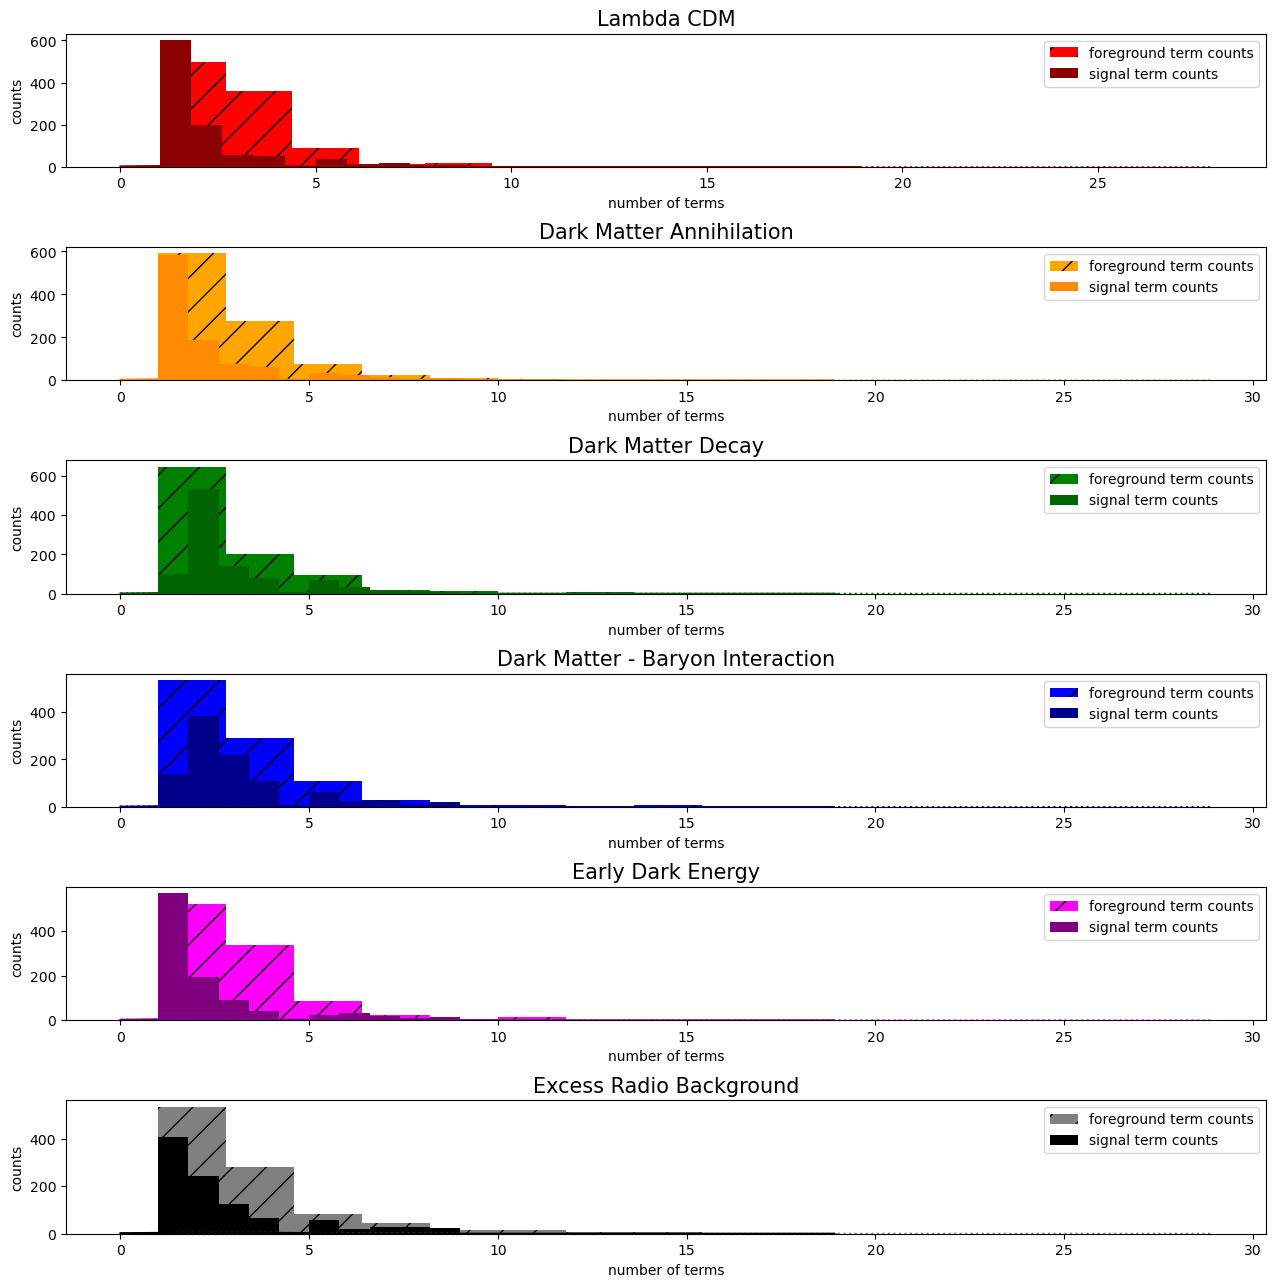

In [23]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6,) = plt.subplots(6,1,figsize=(15, 15))

plt.subplot(6,1,1)
plt.title("Lambda CDM",fontsize=15)
plt.hist(CDM_foreground_terms,bins=10, label="foreground term counts",color="red",hatch="/")
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="red",ls=":")
plt.hist(CDM_signal_terms,bins=10, label="signal term counts",color="darkred")
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkred")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()


plt.subplot(6,1,2)
plt.title("Dark Matter Annihilation",fontsize=15)
plt.hist(DMAN_foreground_terms,bins=10, label="foreground term counts",color="orange",hatch="/")
mean= DMAN_foreground_terms.mean()
std= DMAN_foreground_terms.std()
ranger = np.arange(0,int(DMAN_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="orange",ls=":")
plt.hist(DMAN_signal_terms,bins=10, label="signal term counts",color="darkorange")
mean= DMAN_signal_terms.mean()
std= DMAN_signal_terms.std()
ranger = np.arange(0,int(DMAN_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkorange")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,3)
plt.title("Dark Matter Decay",fontsize=15)
plt.hist(DMD_foreground_terms,bins=10, label="foreground term counts",color="green",hatch="/")
mean= DMD_foreground_terms.mean()
std= DMD_foreground_terms.std()
ranger = np.arange(0,int(DMD_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="green",ls=":")
plt.hist(DMD_signal_terms,bins=10, label="signal term counts",color="darkgreen")
mean= DMD_signal_terms.mean()
std= DMD_signal_terms.std()
ranger = np.arange(0,int(DMD_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkgreen")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,4)
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.hist(MCDM_foreground_terms,bins=10, label="foreground term counts",color="blue",hatch="/")
mean= MCDM_foreground_terms.mean()
std= MCDM_foreground_terms.std()
ranger = np.arange(0,int(MCDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="blue",ls=":")
plt.hist(MCDM_signal_terms,bins=10, label="signal term counts",color="darkblue")
mean= MCDM_signal_terms.mean()
std= MCDM_signal_terms.std()
ranger = np.arange(0,int(MCDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkblue")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,5)
plt.title("Early Dark Energy",fontsize=15)
plt.hist(EDE_foreground_terms,bins=10, label="foreground term counts",color="magenta",hatch="/")
mean= EDE_foreground_terms.mean()
std= EDE_foreground_terms.std()
ranger = np.arange(0,int(EDE_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="magenta",ls=":")
plt.hist(EDE_signal_terms,bins=10, label="signal term counts",color="purple")
mean= EDE_signal_terms.mean()
std= EDE_signal_terms.std()
ranger = np.arange(0,int(EDE_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="purple")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,6)
plt.title("Excess Radio Background",fontsize=15)
plt.hist(ERB_foreground_terms,bins=10, label="foreground term counts",color="gray",hatch="/")
mean= ERB_foreground_terms.mean()
std= ERB_foreground_terms.std()
ranger = np.arange(0,int(ERB_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="gray",ls=":")
plt.hist(ERB_signal_terms,bins=10, label="signal term counts",color="black")
mean= ERB_signal_terms.mean()
std= ERB_signal_terms.std()
ranger = np.arange(0,int(ERB_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="black")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)

plt.savefig(save_path+"SVD_trainingset_test")

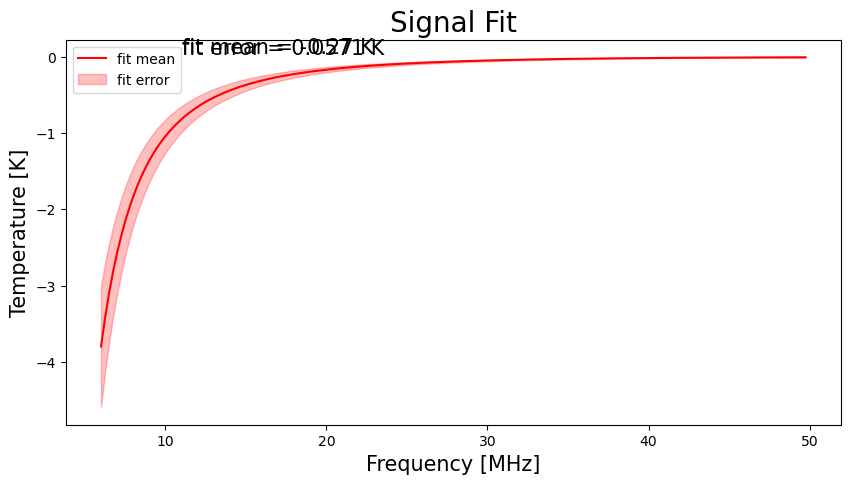

In [19]:
# Not really a necessary plot, but might be nice to see how bad or good fits are visually
plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,sim_curves,label="input signal",c="black")
plt.legend()

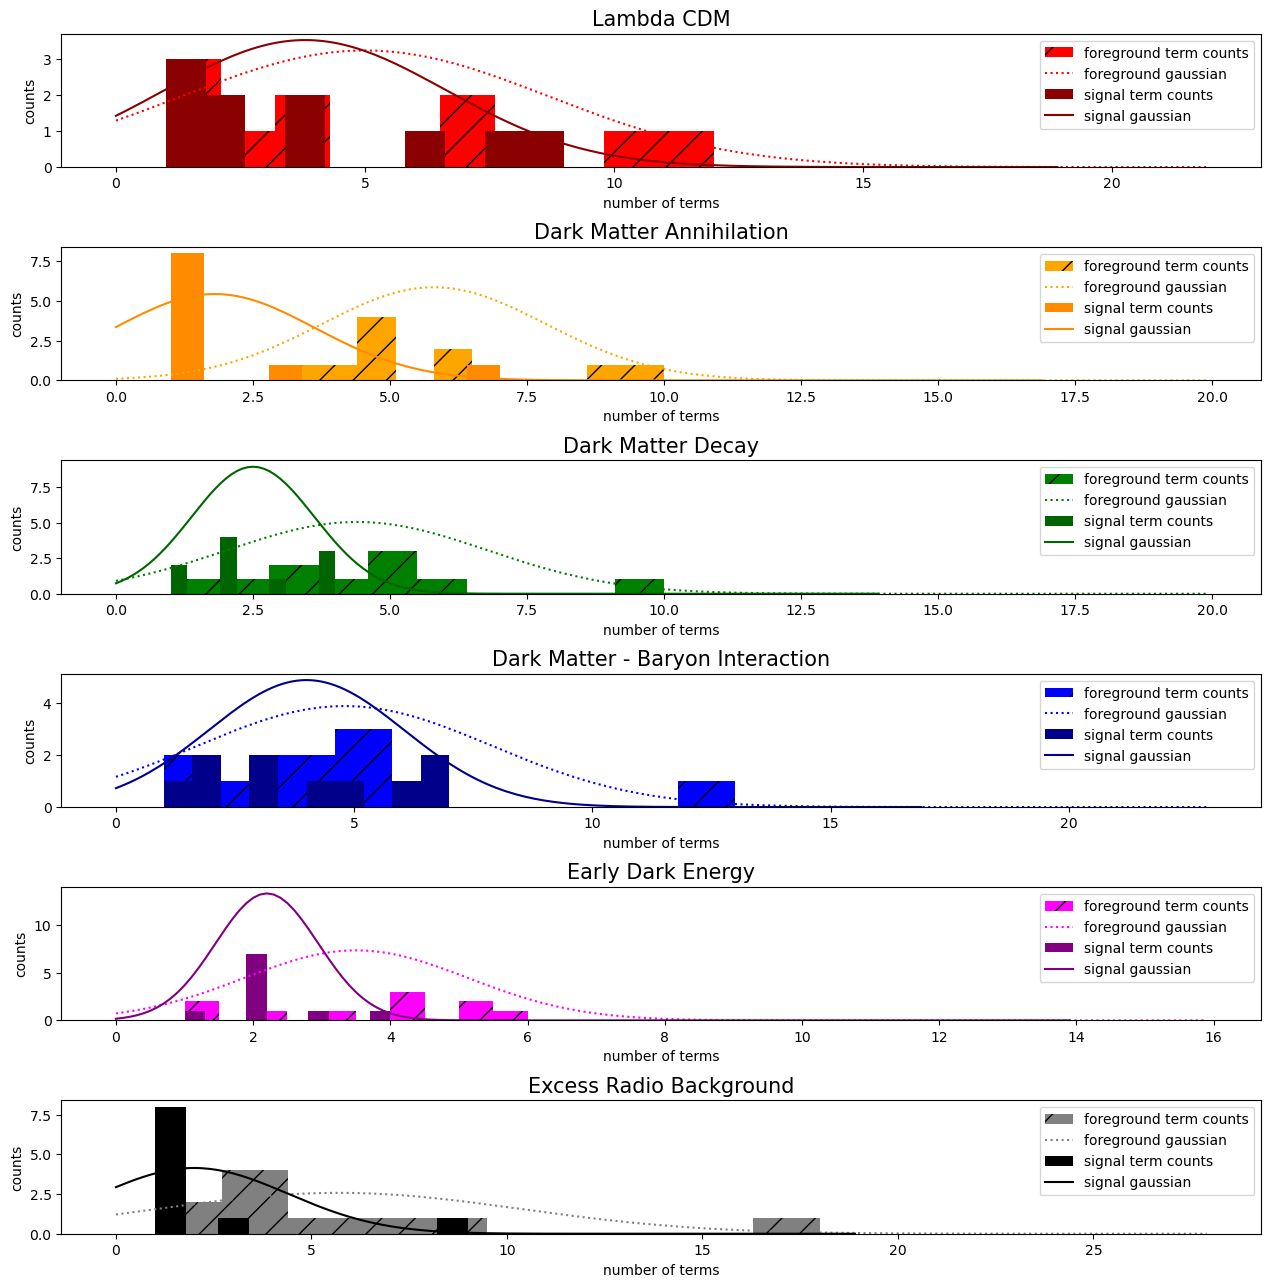

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6,) = plt.subplots(6,1,figsize=(15, 15))

plt.subplot(6,1,1)
plt.title("Lambda CDM",fontsize=15)
plt.hist(CDM_foreground_terms,bins=10, label="foreground term counts",color="red",hatch="/")
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="red",ls=":",label="foreground gaussian")
plt.hist(CDM_signal_terms,bins=10, label="signal term counts",color="darkred")
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkred",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()


plt.subplot(6,1,2)
plt.title("Dark Matter Annihilation",fontsize=15)
plt.hist(DMAN_foreground_terms,bins=10, label="foreground term counts",color="orange",hatch="/")
mean= DMAN_foreground_terms.mean()
std= DMAN_foreground_terms.std()
ranger = np.arange(0,int(DMAN_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="orange",ls=":",label="foreground gaussian")
plt.hist(DMAN_signal_terms,bins=10, label="signal term counts",color="darkorange")
mean= DMAN_signal_terms.mean()
std= DMAN_signal_terms.std()
ranger = np.arange(0,int(DMAN_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkorange",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,3)
plt.title("Dark Matter Decay",fontsize=15)
plt.hist(DMD_foreground_terms,bins=10, label="foreground term counts",color="green",hatch="/")
mean= DMD_foreground_terms.mean()
std= DMD_foreground_terms.std()
ranger = np.arange(0,int(DMD_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="green",ls=":",label="foreground gaussian")
plt.hist(DMD_signal_terms,bins=10, label="signal term counts",color="darkgreen")
mean= DMD_signal_terms.mean()
std= DMD_signal_terms.std()
ranger = np.arange(0,int(DMD_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkgreen",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,4)
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.hist(MCDM_foreground_terms,bins=10, label="foreground term counts",color="blue",hatch="/")
mean= MCDM_foreground_terms.mean()
std= MCDM_foreground_terms.std()
ranger = np.arange(0,int(MCDM_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="blue",ls=":",label="foreground gaussian")
plt.hist(MCDM_signal_terms,bins=10, label="signal term counts",color="darkblue")
mean= MCDM_signal_terms.mean()
std= MCDM_signal_terms.std()
ranger = np.arange(0,int(MCDM_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="darkblue",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,5)
plt.title("Early Dark Energy",fontsize=15)
plt.hist(EDE_foreground_terms,bins=10, label="foreground term counts",color="magenta",hatch="/")
mean= EDE_foreground_terms.mean()
std= EDE_foreground_terms.std()
ranger = np.arange(0,int(EDE_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="magenta",ls=":",label="foreground gaussian")
plt.hist(EDE_signal_terms,bins=10, label="signal term counts",color="purple")
mean= EDE_signal_terms.mean()
std= EDE_signal_terms.std()
ranger = np.arange(0,int(EDE_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="purple",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplot(6,1,6)
plt.title("Excess Radio Background",fontsize=15)
plt.hist(ERB_foreground_terms,bins=10, label="foreground term counts",color="gray",hatch="/")
mean= ERB_foreground_terms.mean()
std= ERB_foreground_terms.std()
ranger = np.arange(0,int(ERB_foreground_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*30,color="gray",ls=":",label="foreground gaussian")
plt.hist(ERB_signal_terms,bins=10, label="signal term counts",color="black")
mean= ERB_signal_terms.mean()
std= ERB_signal_terms.std()
ranger = np.arange(0,int(ERB_signal_terms.max())+10,0.1)
plt.plot(ranger,scipy.stats.norm.pdf(ranger,loc=mean,scale=std)*25,c="black",label="signal gaussian")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)

plt.savefig(save_path+"SVD_trainingset_test")



In [205]:
std

3.687817782917155